<a href="https://colab.research.google.com/github/Abbhiraami/ML_AI_masters/blob/main/RNN_Assignment/RNN_Assg_Stock_Price_Prediction_AbbhiraamiS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')\

### Packages for combinators
import itertools

## Display python tables
from IPython.display import display

### Sklearn essentials

import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


### Tensorflow essentials

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN, Dropout, LSTM, GRU,Activation

### Optimizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import Callback,ReduceLROnPlateau,EarlyStopping

### Extracting files from google drive
from google.colab import drive
from os import listdir

### Importing udf library
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive')

import stock_preds_utils as utils

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [3]:
!unzip "/content/drive/MyDrive/RNN_Stock_Starter_Dataset.zip" -d "/content/RNN_data"

Archive:  /content/drive/MyDrive/RNN_Stock_Starter_Dataset.zip
  inflating: /content/RNN_data/RNN_Stock_Starter_Dataset/RNN_Stocks_Data/AMZN_stocks_data.csv  
  inflating: /content/RNN_data/RNN_Stock_Starter_Dataset/RNN_Stocks_Data/MSFT_stocks_data.csv  
  inflating: /content/RNN_data/RNN_Stock_Starter_Dataset/RNN_Stocks_Data/GOOGL_stocks_data.csv  
  inflating: /content/RNN_data/RNN_Stock_Starter_Dataset/RNN_Assg_Stock_Price_Prediction_Starter.ipynb  
  inflating: /content/RNN_data/RNN_Stock_Starter_Dataset/RNN_Stocks_Data/IBM_stocks_data.csv  


In [4]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
root_dir="/content/RNN_data/RNN_Stock_Starter_Dataset/RNN_Stocks_Data"
def read_data(root_dir):
  """
  Input: Mounted root directory
  Functionality: Extacts all the files and concatenates
  Output: Concatenated data
  """
  filnames=listdir(root_dir)
  df_all_comps=pd.DataFrame()
  for fil in  filnames:
    df=pd.read_csv(f"{root_dir}/{fil}")
    df_all_comps=pd.concat([df_all_comps,df])
  return df_all_comps

#### Data-Extracted
df_stocks_all=read_data(root_dir).reset_index()
df_stocks_all.drop_duplicates(inplace=True)
print(f"Shape of the data:{df_stocks_all.shape}")
df_stocks_all.head()


Shape of the data:(12077, 8)


,index,Date,Open,High,Low,Close,Volume,Name
0,0,2006-01-03,26.25,27.00,26.10,26.84,79974418,MSFT
1,1,2006-01-04,26.77,27.08,26.77,26.97,57975661,MSFT
2,2,2006-01-05,26.96,27.13,26.91,26.99,48247610,MSFT
3,3,2006-01-06,26.89,27.00,26.49,26.91,100969092,MSFT
4,4,2006-01-09,26.93,27.07,26.76,26.86,55627836,MSFT


In [5]:
### 1. Pivoting the table
companies_name=df_stocks_all.Name.unique()
indicators=['Open', 'High', 'Low', 'Volume','Close']
print(indicators)
all_stocks_pivoted=df_stocks_all.pivot(index="Date",columns="Name",values=["Open","High","Low","Close","Volume"]).sort_values('Date',ascending=True).reset_index()
all_stocks_pivoted.columns=['_'.join(col).strip() for col in all_stocks_pivoted.columns ]
display(all_stocks_pivoted.head())
print(f"Shape of dataframe: {all_stocks_pivoted.shape}")
print("Missing values")
### Sorting columns company-wise
all_stocks_pivoted=all_stocks_pivoted[["Date_"]+[f"{ind}_{comp}" for comp in companies_name for ind in indicators]]
all_stocks_pivoted.describe()

['Open', 'High', 'Low', 'Volume', 'Close']


,Date_,Open_AMZN,Open_GOOGL,Open_IBM,Open_MSFT,High_AMZN,High_GOOGL,High_IBM,High_MSFT,Low_AMZN,...,Low_IBM,Low_MSFT,Close_AMZN,Close_GOOGL,Close_IBM,Close_MSFT,Volume_AMZN,Volume_GOOGL,Volume_IBM,Volume_MSFT
0,2006-01-03,47.47,211.47,82.45,26.25,47.85,218.05,82.55,27.00,46.25,...,80.81,26.10,47.58,217.83,82.06,26.84,7582127.0,13137450.0,11715200.0,79974418.0
1,2006-01-04,47.48,222.17,82.20,26.77,47.73,224.70,82.50,27.08,46.69,...,81.33,26.77,47.25,222.84,81.95,26.97,7440914.0,15292353.0,9840600.0,57975661.0
2,2006-01-05,47.16,223.22,81.40,26.96,48.20,226.00,82.90,27.13,47.11,...,81.00,26.91,47.65,225.85,82.50,26.99,5417258.0,10815661.0,7213500.0,48247610.0
3,2006-01-06,47.97,228.66,83.95,26.89,48.58,235.49,85.03,27.00,47.32,...,83.41,26.49,47.87,233.06,84.95,26.91,6154285.0,17759521.0,8197400.0,100969092.0
4,2006-01-09,46.55,233.44,84.10,26.93,47.10,236.94,84.25,27.07,46.40,...,83.38,26.76,47.08,233.68,83.73,26.86,8945056.0,12795837.0,6858200.0,55627836.0


Shape of dataframe: (3020, 21)
Missing values


,Open_MSFT,High_MSFT,Low_MSFT,Volume_MSFT,Close_MSFT,Open_AMZN,High_AMZN,Low_AMZN,Volume_AMZN,Close_AMZN,Open_GOOGL,High_GOOGL,Low_GOOGL,Volume_GOOGL,Close_GOOGL,Open_IBM,High_IBM,Low_IBM,Volume_IBM,Close_IBM
count,3019.000000,3019.000000,3019.000000,3.019000e+03,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03,3019.000000,3019.000000,3020.000000,3019.000000,3.020000e+03,3020.000000
mean,36.496817,36.827903,36.173190,5.161762e+07,36.513412,299.335310,302.371163,296.037695,5.931712e+06,299.376231,428.200802,431.835618,424.130275,3.551504e+06,428.044001,145.515545,146.681738,144.471597,5.773301e+06,145.617278
std,14.683337,14.742483,14.620057,3.114958e+07,14.694656,280.120547,281.826442,277.927134,5.122034e+06,279.980161,236.320026,237.514087,234.923747,3.038599e+06,236.343238,37.554946,37.613446,37.477641,3.192831e+06,37.529387
min,15.200000,15.620000,14.870000,7.425603e+06,15.150000,26.090000,26.300000,25.760000,9.864350e+05,26.070000,131.390000,134.820000,123.770000,5.211410e+05,128.850000,72.740000,73.940000,69.500000,2.542560e+05,71.740000
25%,26.785000,27.045000,26.535000,3.136557e+07,26.835000,81.175000,82.580000,79.725000,3.137037e+06,81.090000,247.775000,250.190000,244.035000,1.760854e+06,247.605000,116.405000,117.765000,115.490000,3.622681e+06,116.525000
50%,29.990000,30.230000,29.780000,4.617529e+07,30.000000,205.330000,208.000000,202.100000,4.724100e+06,205.440000,310.480000,312.810000,307.790000,2.517630e+06,310.080000,149.610000,150.330000,148.470000,4.928852e+06,149.315000
75%,44.545000,44.980000,44.090000,6.322291e+07,44.400000,375.570000,379.155000,373.000000,7.135246e+06,375.140000,572.140000,575.975000,565.900000,4.242182e+06,570.770000,178.445000,179.762500,177.330000,6.965014e+06,178.685000
max,87.120000,87.500000,86.230000,5.910786e+08,86.850000,1204.880000,1213.410000,1191.150000,1.044046e+08,1195.830000,1083.020000,1086.490000,1072.270000,4.118289e+07,1085.090000,215.380000,215.900000,214.300000,3.077428e+07,215.800000


#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [6]:
# Handle Missing Values

### Extract only missing rows
missing_rows=all_stocks_pivoted[all_stocks_pivoted.isna().any(axis=1)]
display(missing_rows)

# Remove the missing data if it is more than 3 columns
all_stocks_pivoted=all_stocks_pivoted[~(all_stocks_pivoted.isna().sum(axis=1)>3)] ###
print(f"Shape of dataframe after dropping NA columns: {all_stocks_pivoted.shape}")
print("Missing values")
all_stocks_pivoted.isna().sum()
all_stocks_pivoted[all_stocks_pivoted.isna().any(axis=1)]

### Handle missing data in time-series data
all_stocks_pivoted=all_stocks_pivoted.fillna(all_stocks_pivoted.select_dtypes(include=np.number).median())
all_stocks_pivoted.isna().sum()
# all_stocks_pivoted.head(10)

,Date_,Open_MSFT,High_MSFT,Low_MSFT,Volume_MSFT,Close_MSFT,Open_AMZN,High_AMZN,Low_AMZN,Volume_AMZN,...,Open_GOOGL,High_GOOGL,Low_GOOGL,Volume_GOOGL,Close_GOOGL,Open_IBM,High_IBM,Low_IBM,Volume_IBM,Close_IBM
1068,2010-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,128.95,129.31,127.55,4980625.0,128.25
2913,2017-07-31,73.3,73.44,72.41,23600054.0,72.7,1019.05,1019.05,987.02,7352063.0,...,960.0,961.19,941.72,2293389.0,945.5,NaN,144.93,NaN,4355718.0,144.67


Shape of dataframe after dropping NA columns: (3019, 21)
Missing values


,0
Date_,0
Open_MSFT,0
High_MSFT,0
Low_MSFT,0
Volume_MSFT,0
Close_MSFT,0
Open_AMZN,0
High_AMZN,0
Low_AMZN,0
Volume_AMZN,0


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

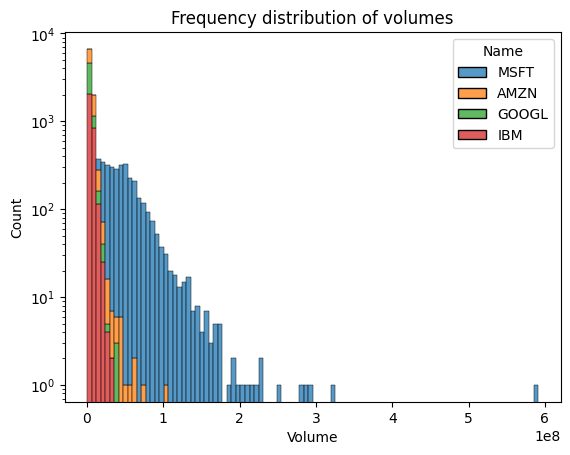

In [7]:
# Frequency distribution of volumes
## adjust bin size of histogram
sns.histplot(data=df_stocks_all,x="Volume",bins=100,hue="Name",multiple="stack")
plt.title("Frequency distribution of volumes")
plt.yscale('log')
# plt.xscale('log')
plt.show()

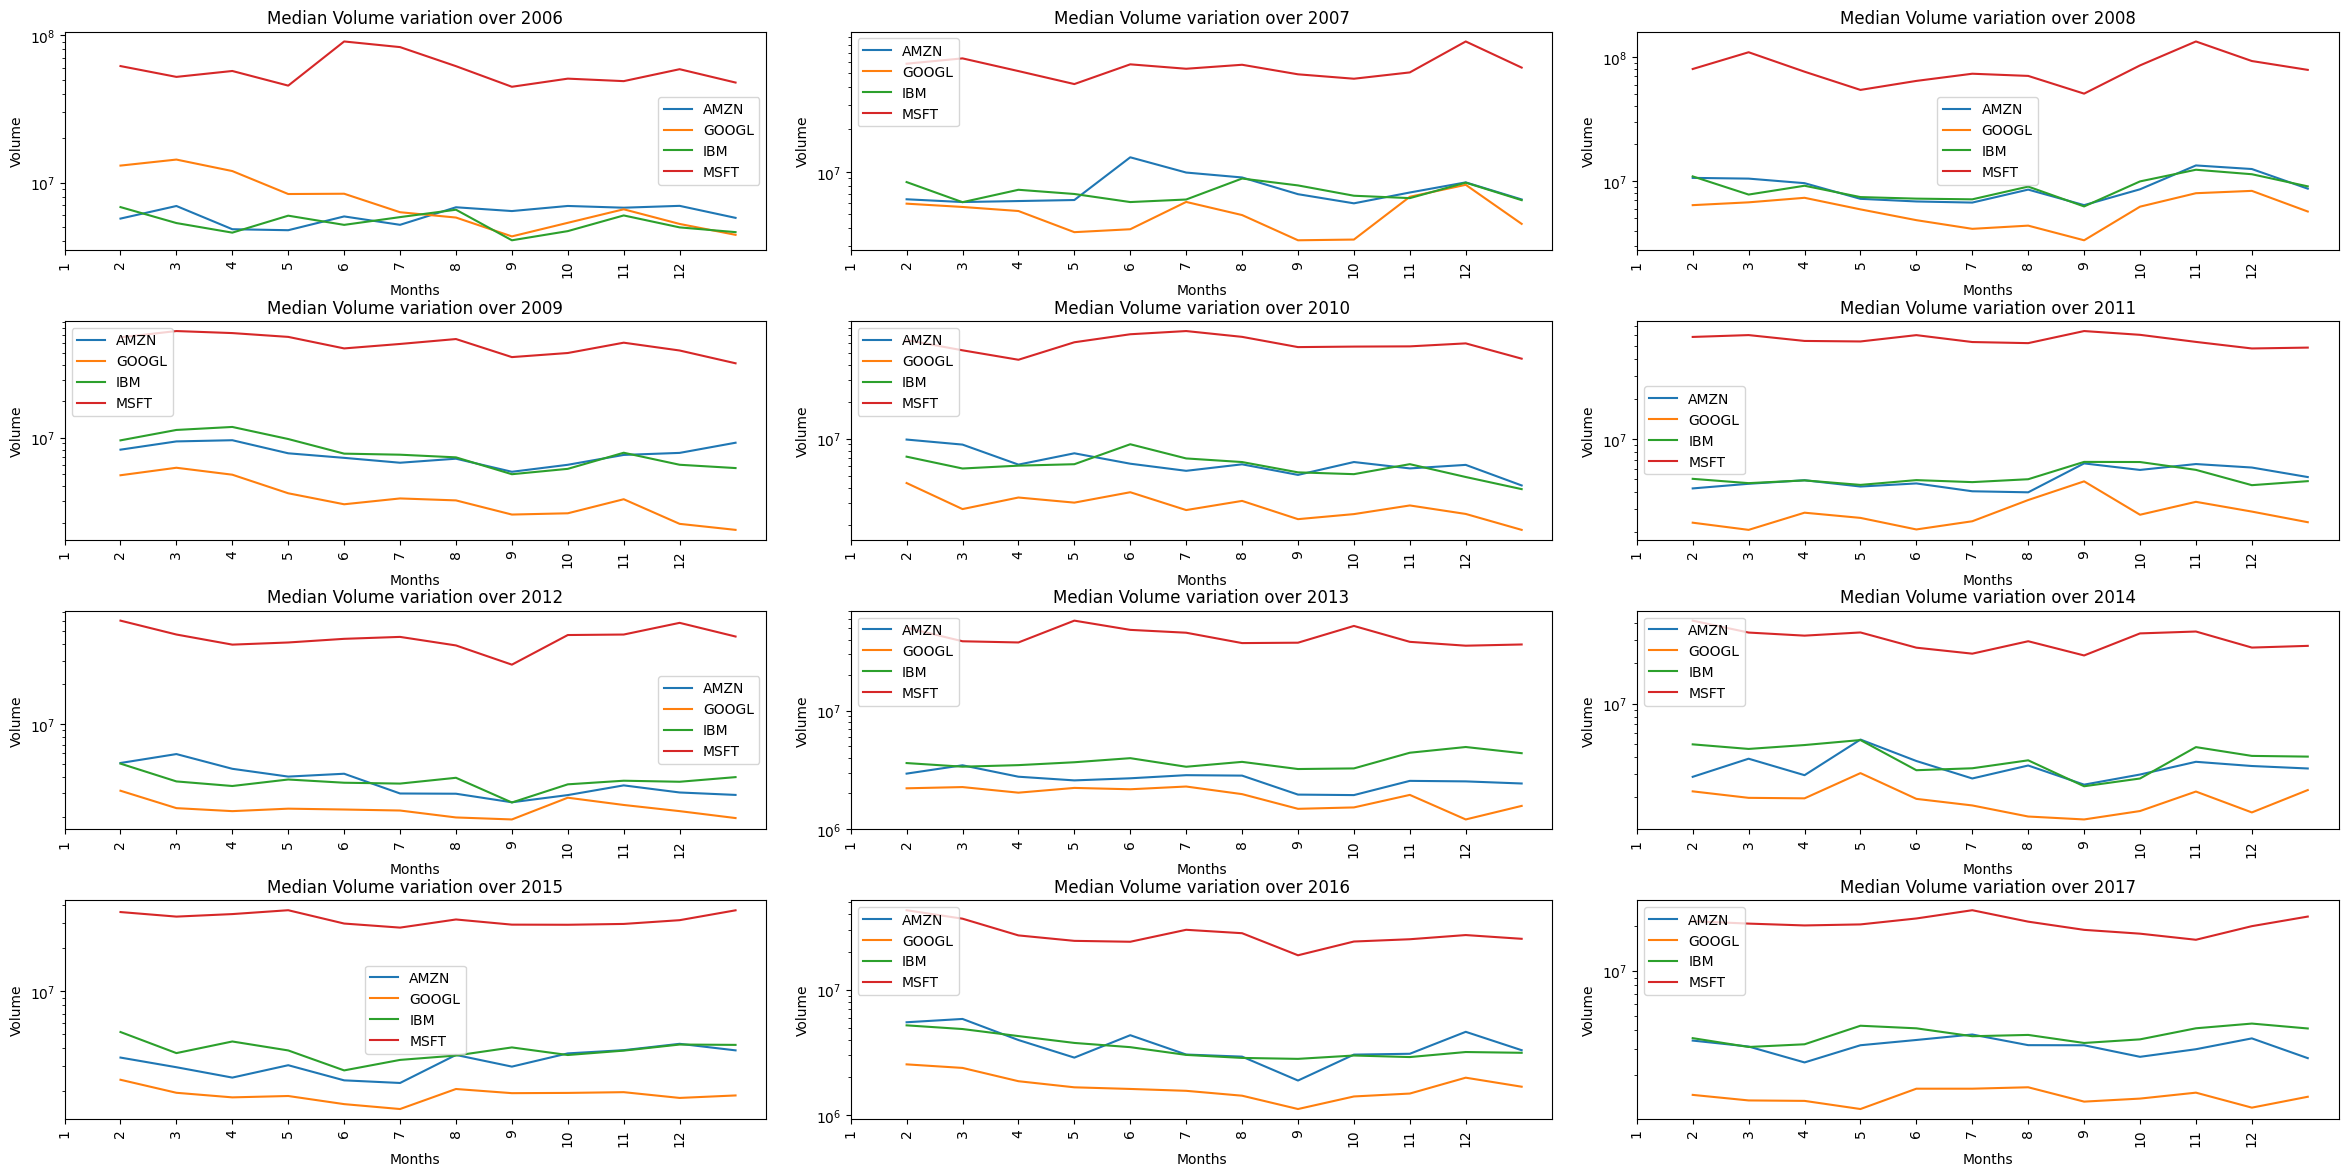

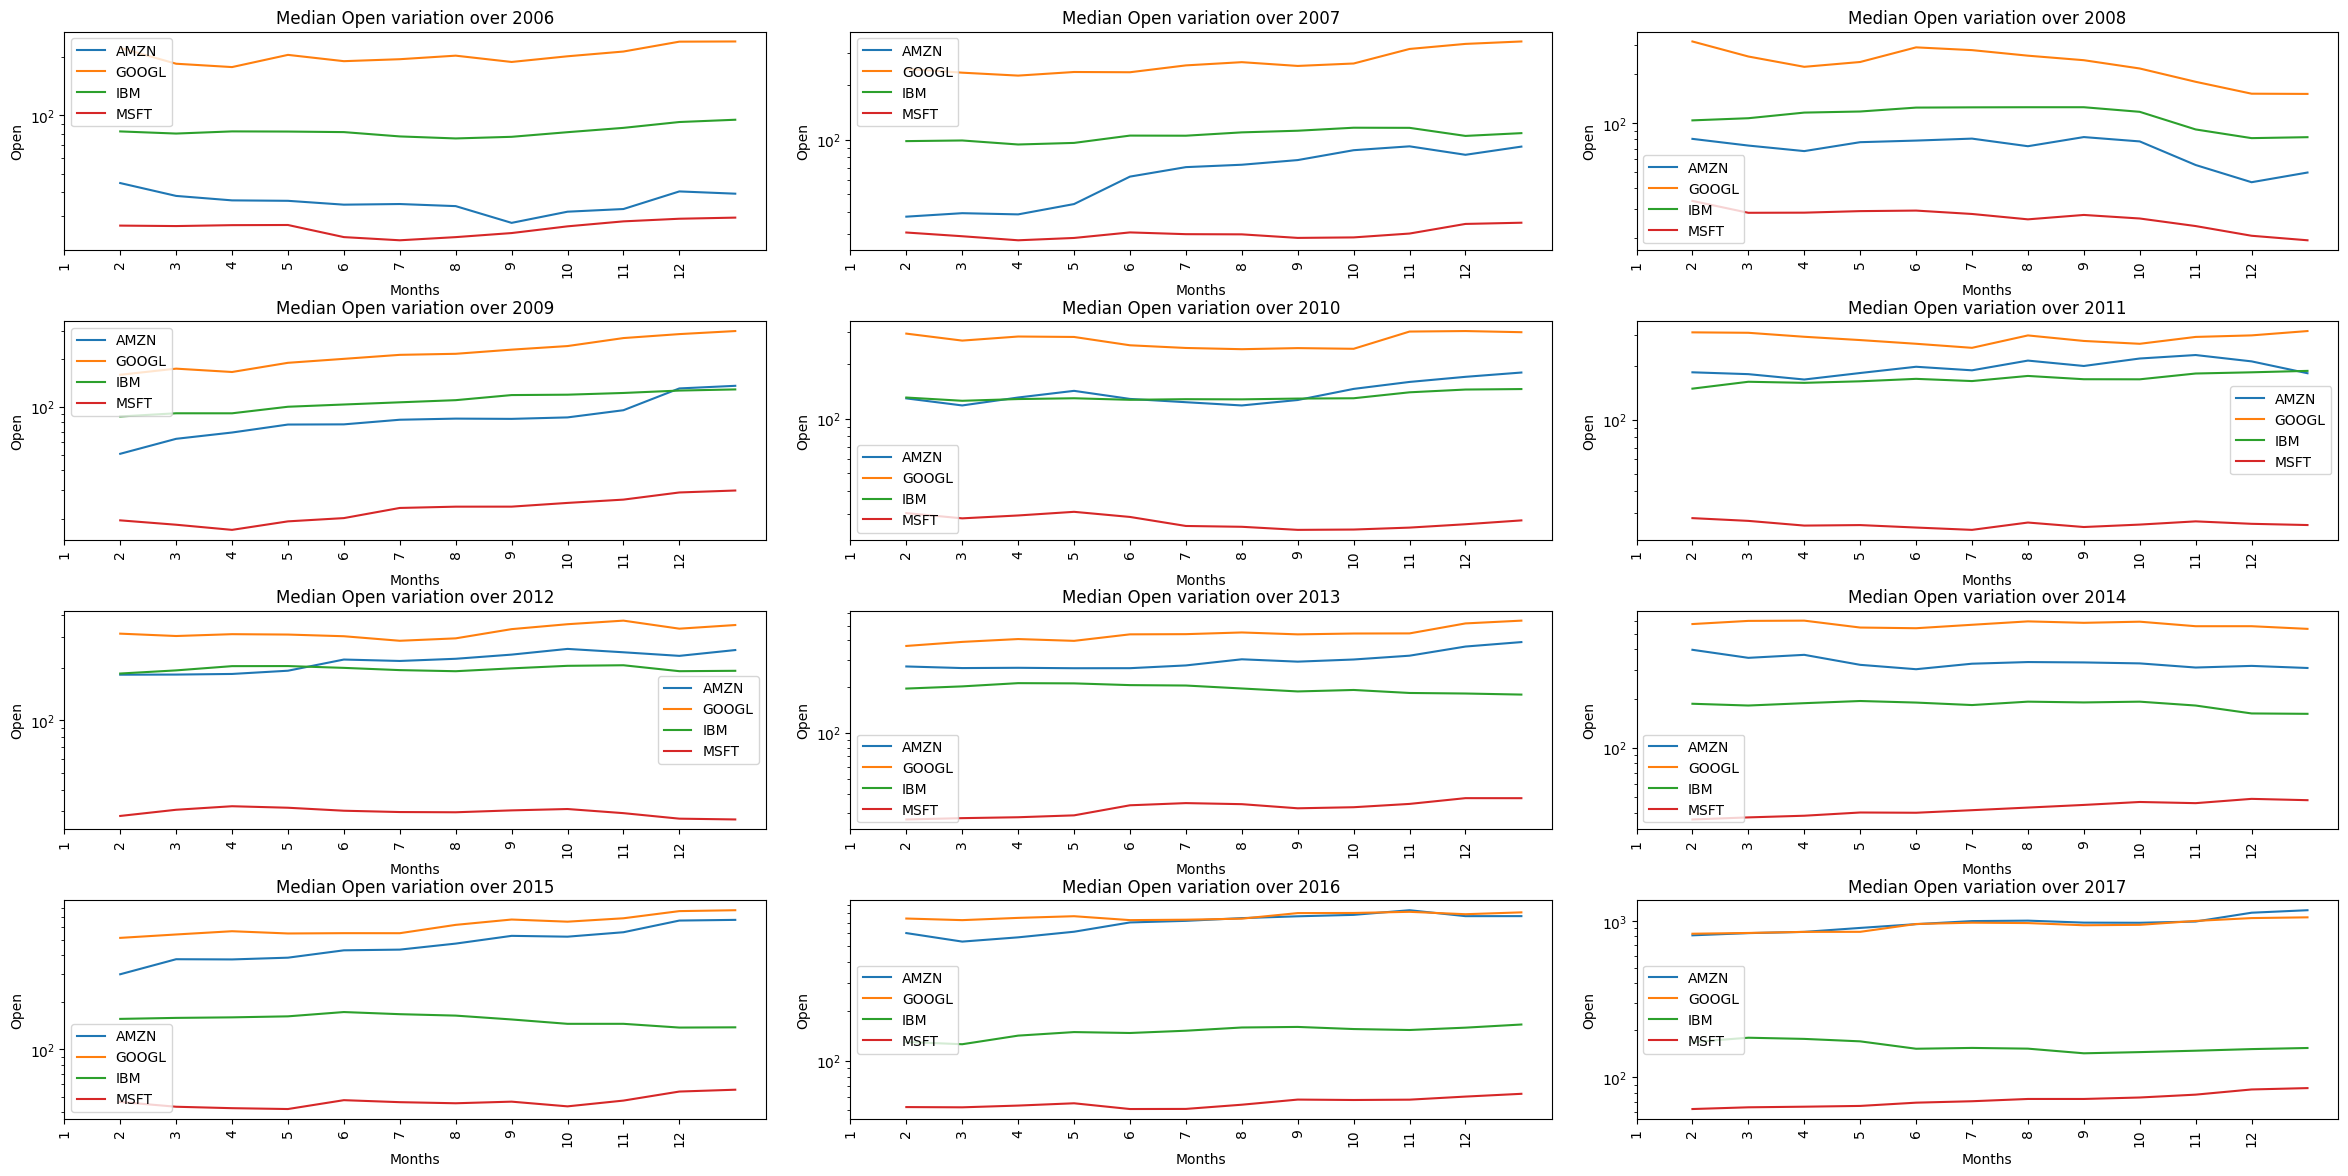

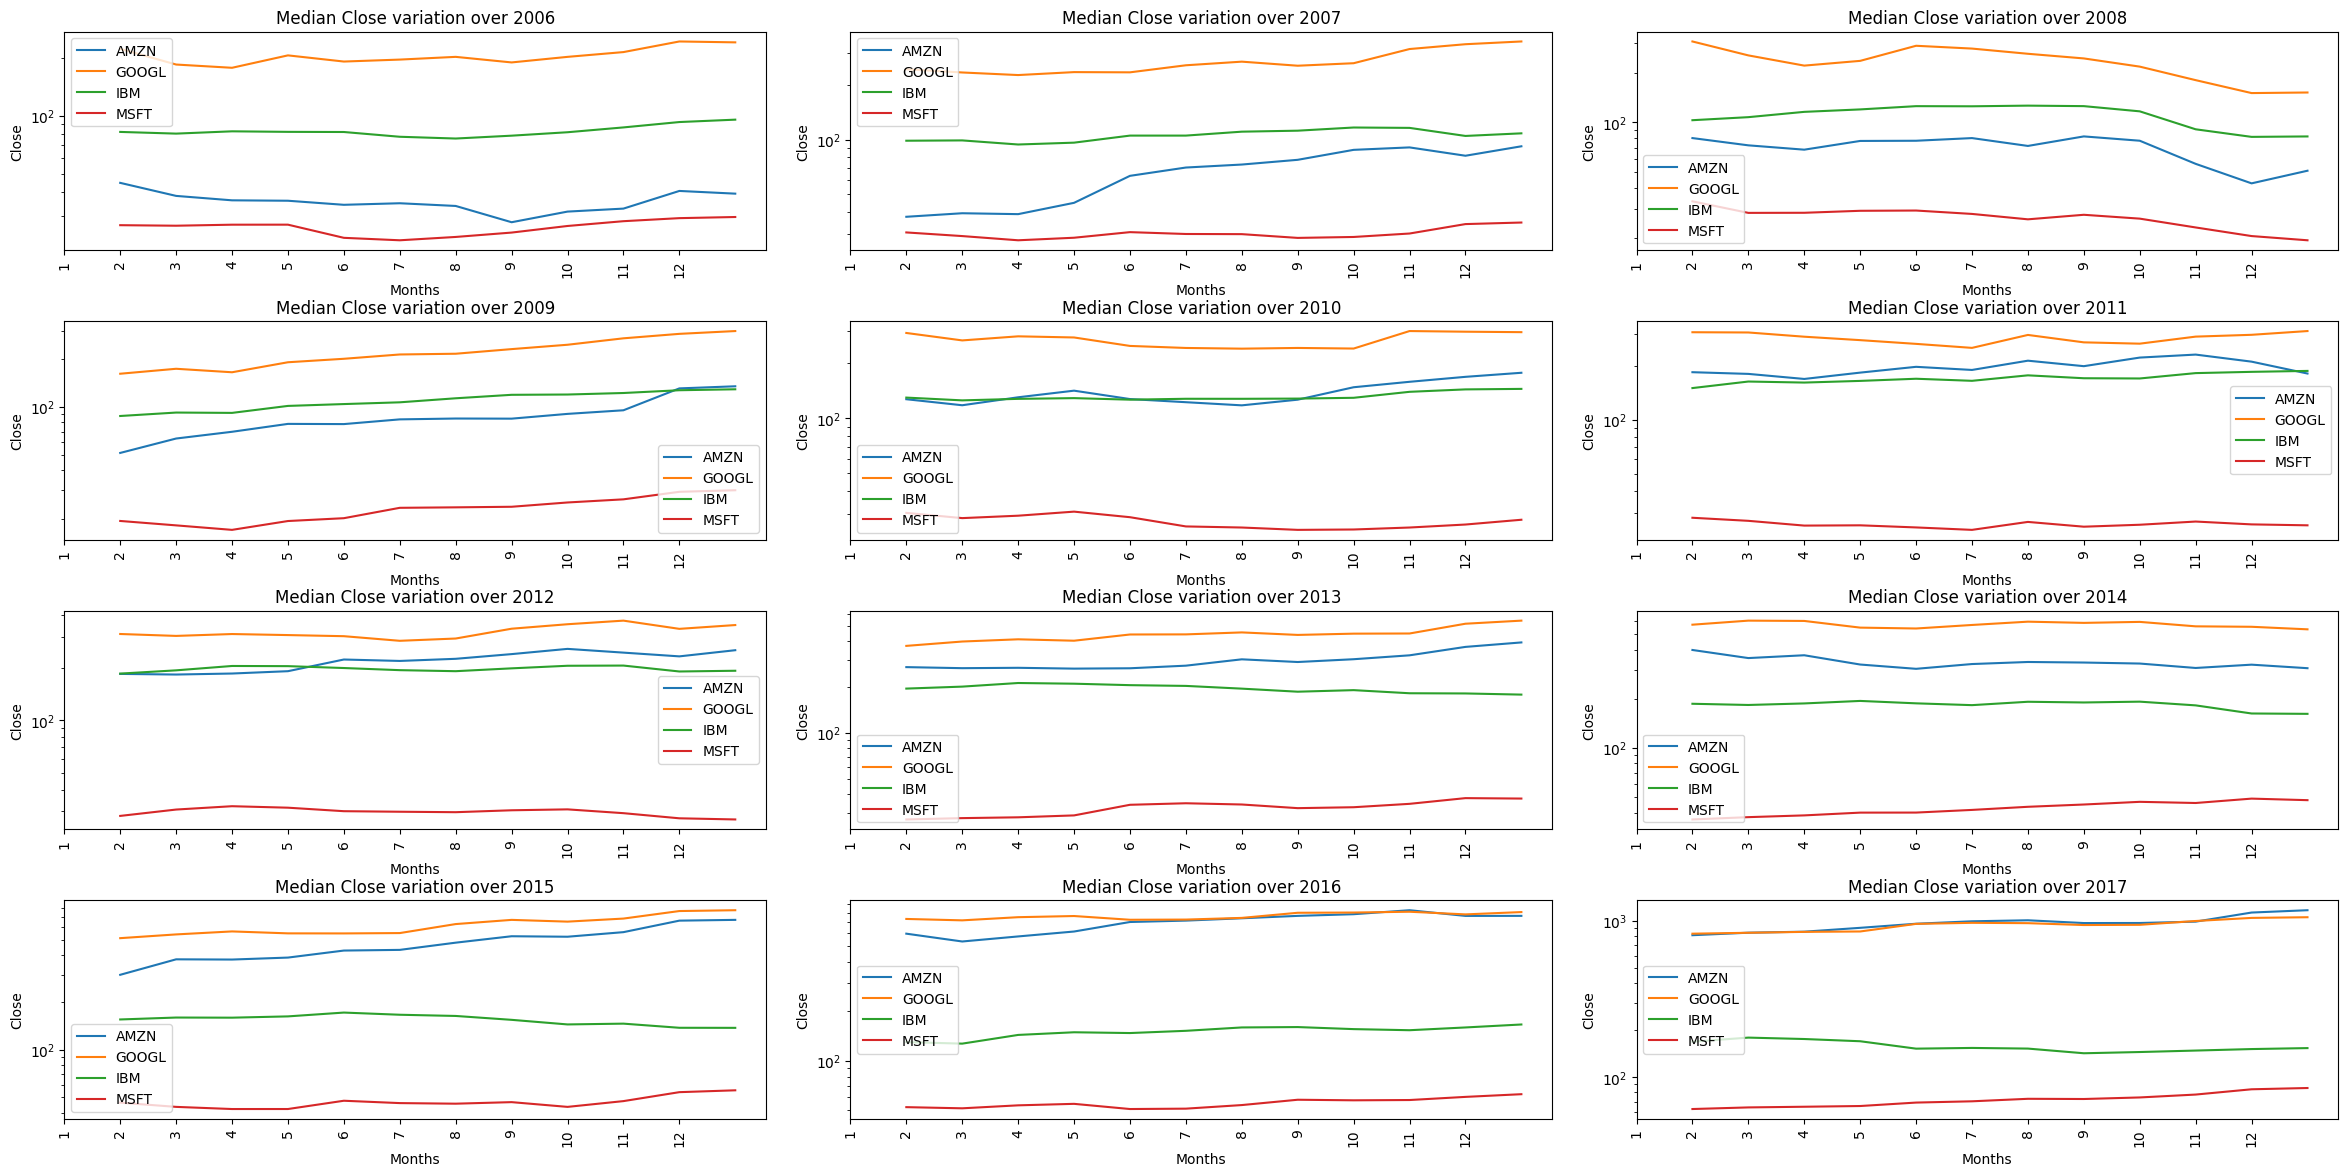

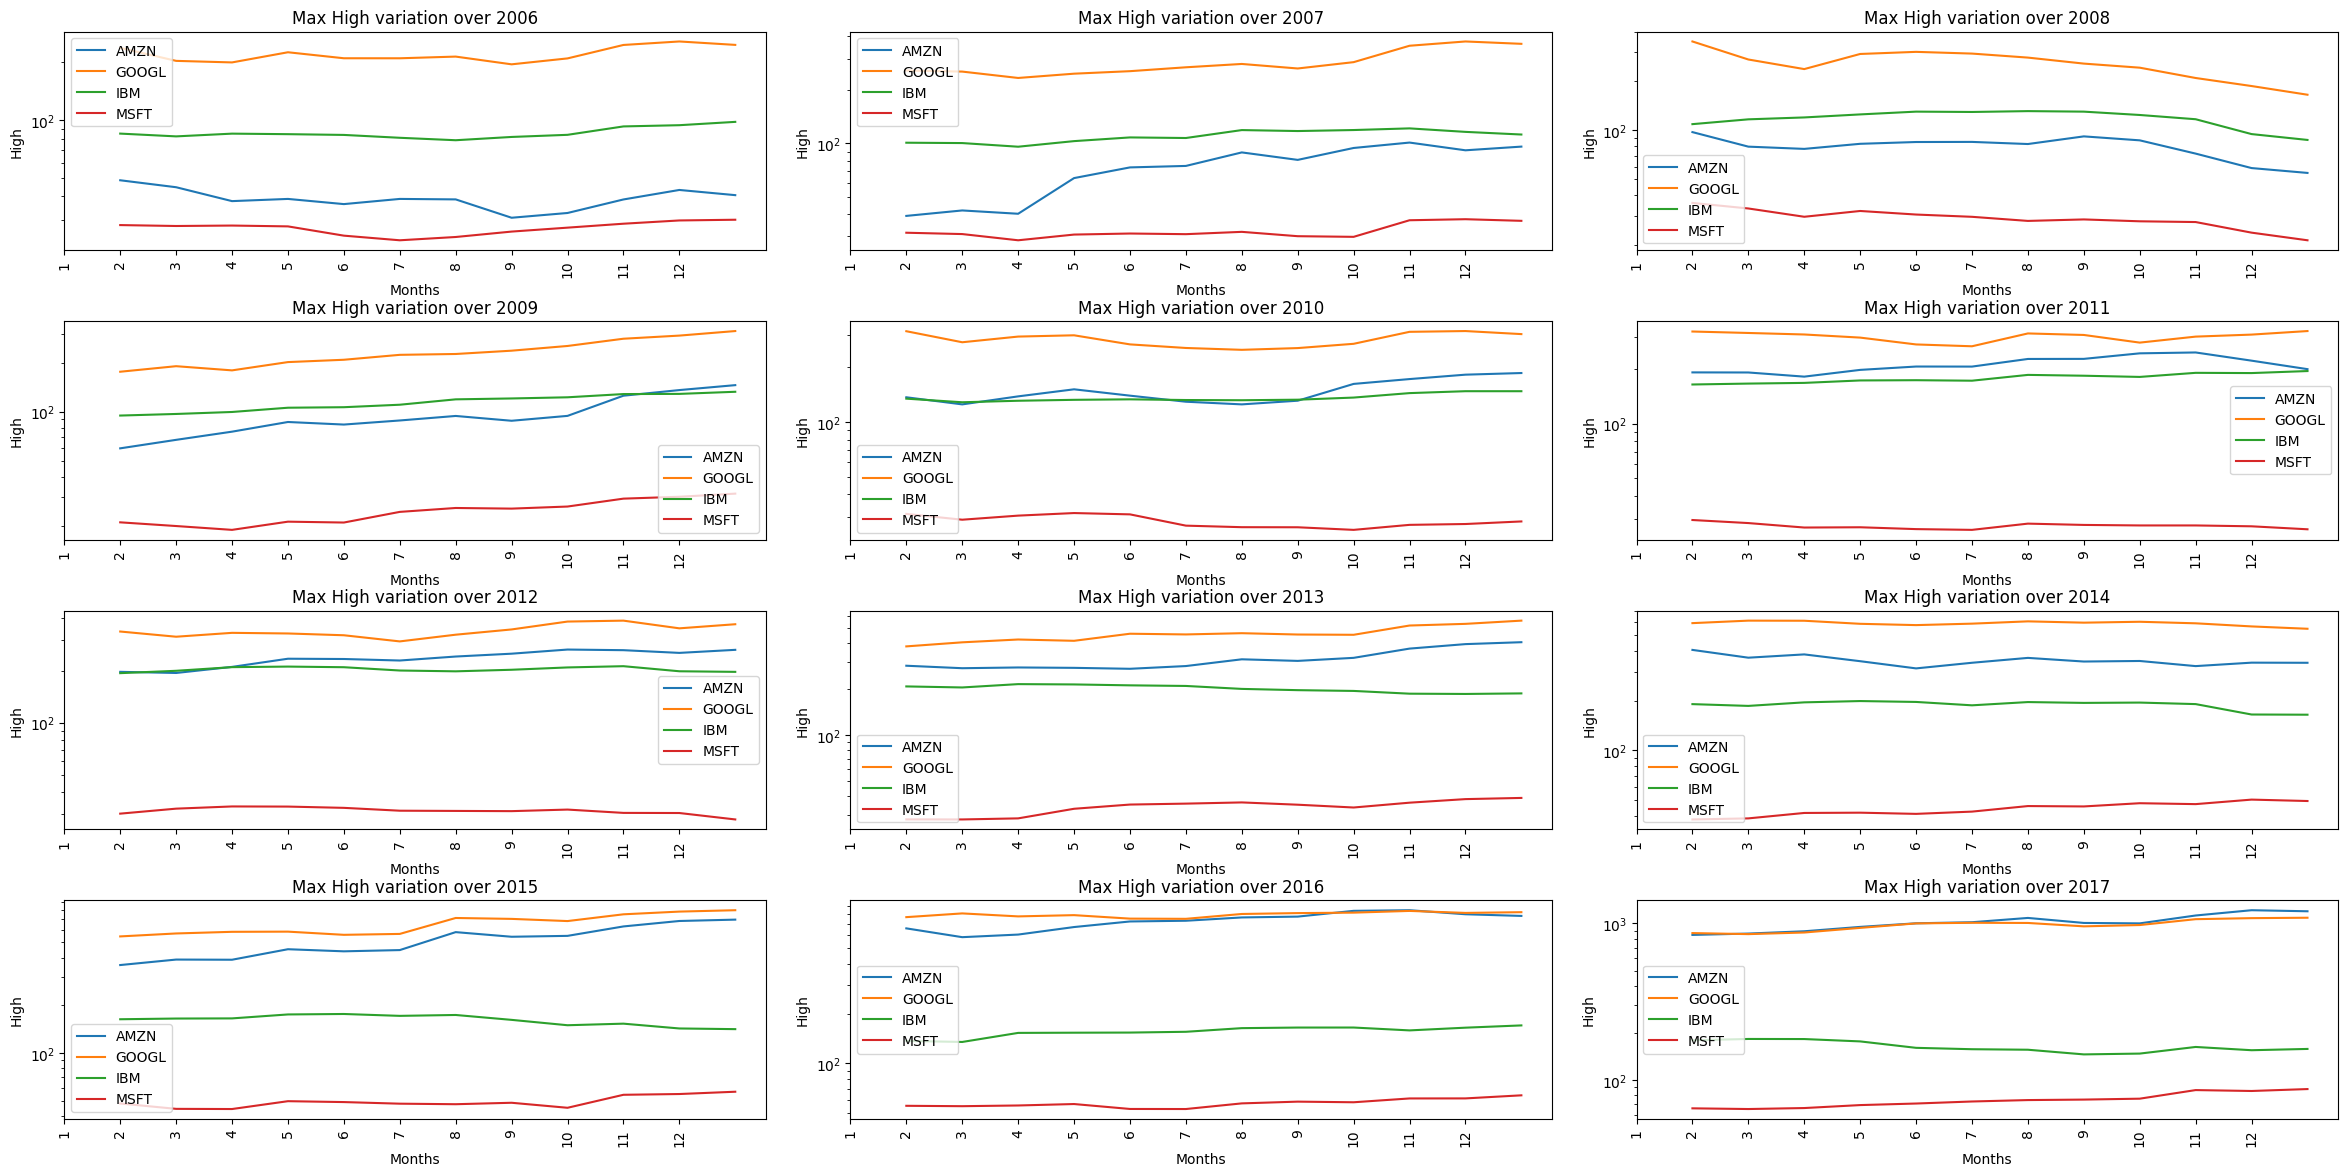

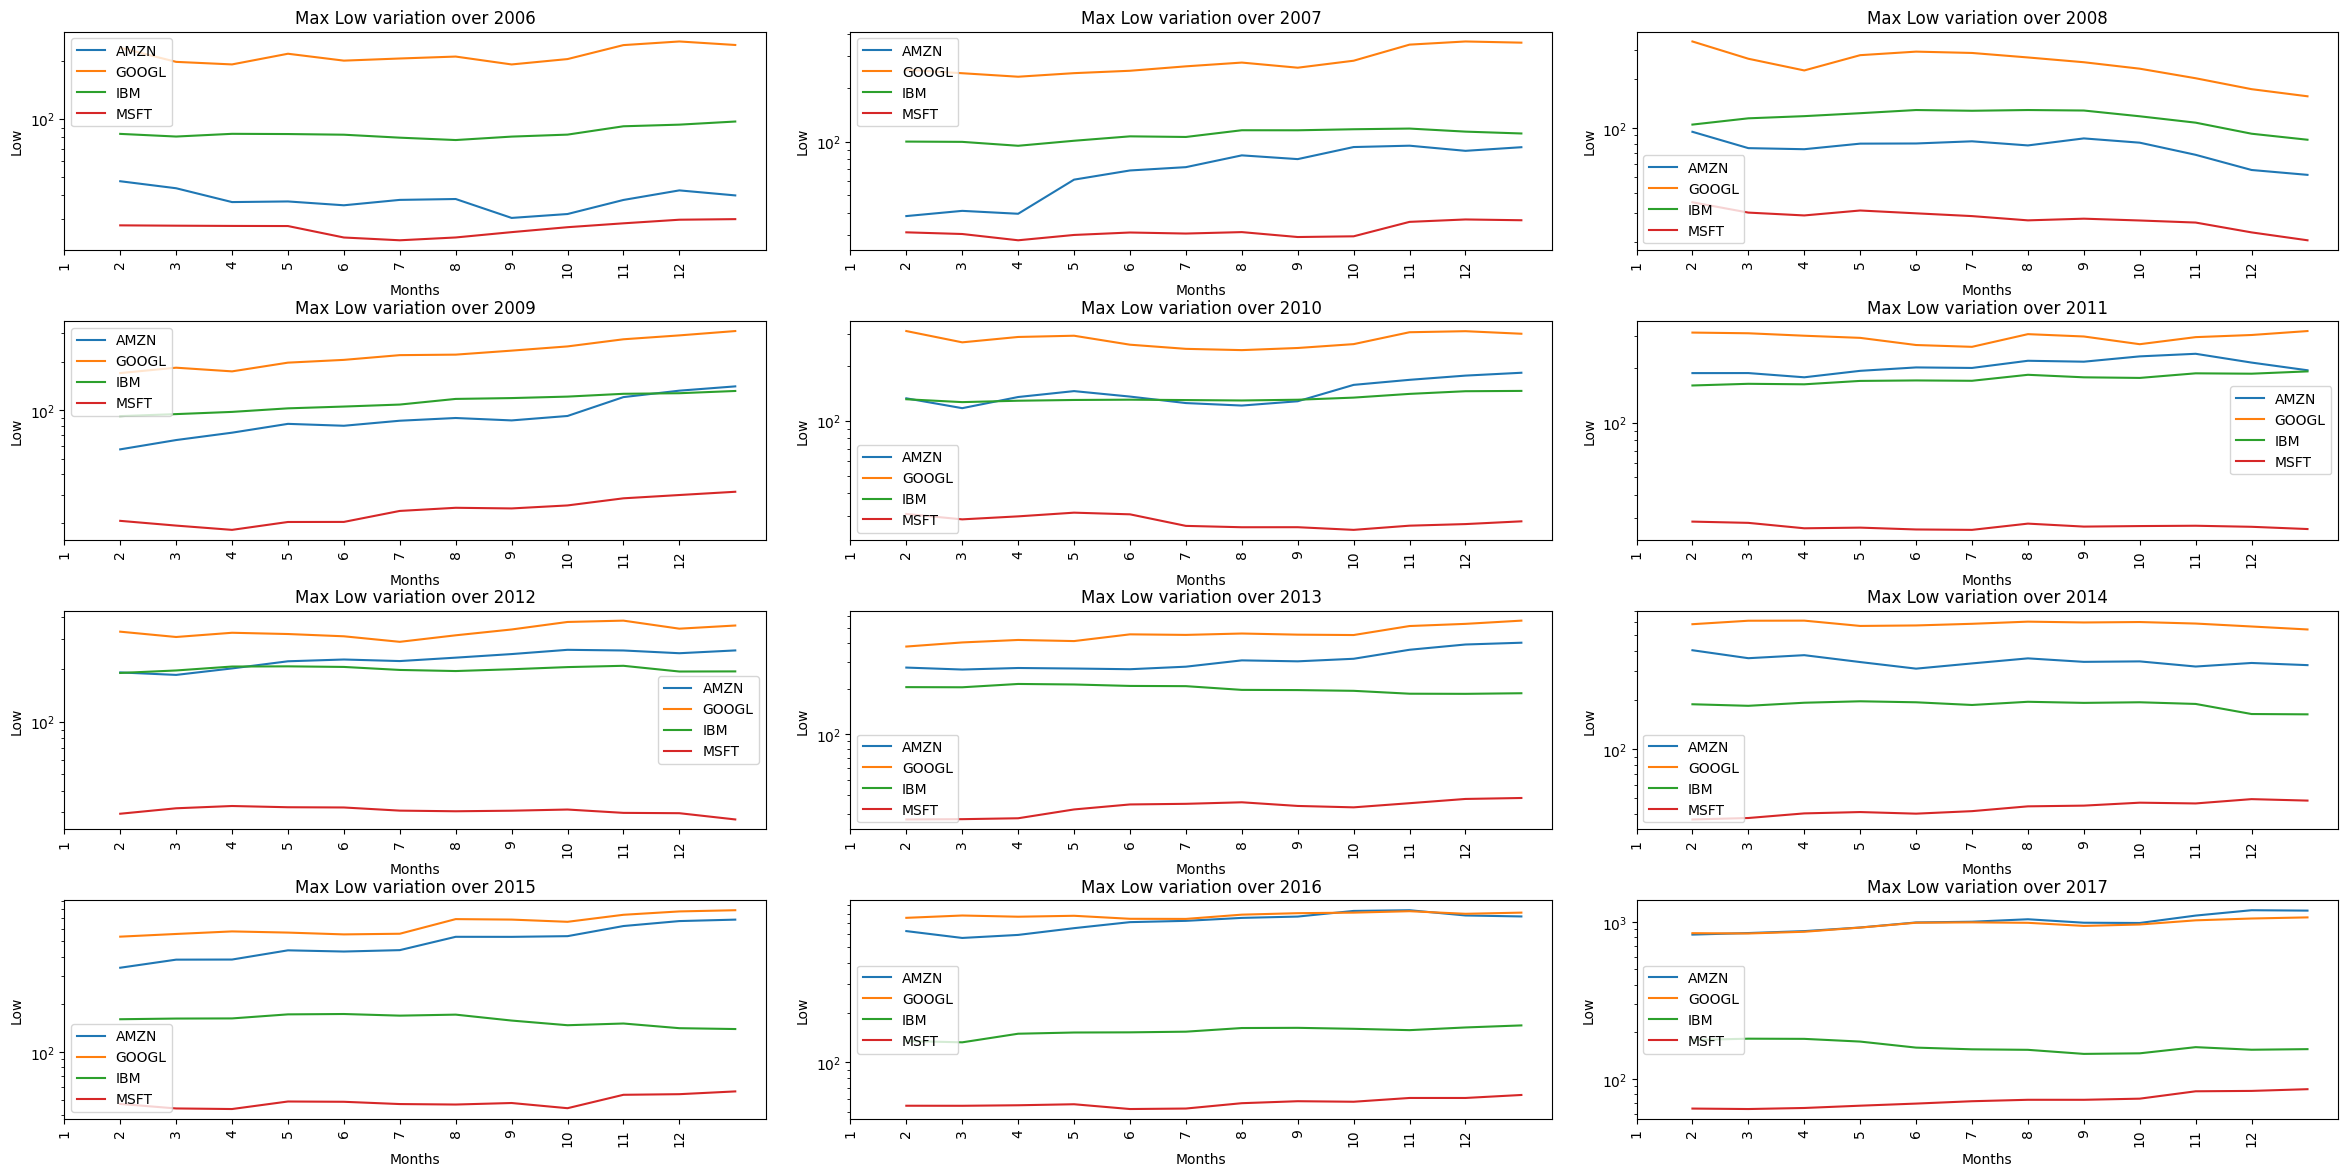

12

In [8]:
# Stock volume variation over time

def plot_over_time(data=None,attribute=None,agg_method='mean',remove_comp=None):

  data_sorted=data.sort_values(["Name","Date"],ascending=True)
  data_sorted['year']=pd.to_datetime(data_sorted['Date']).dt.year
  data_sorted['month']=pd.to_datetime(data_sorted['Date']).dt.month
  data_sorted['day']=pd.to_datetime(data_sorted['Date']).dt.day



  ## Year and company counts
  year_list=data_sorted['year'].unique()
  if remove_comp==None:
    comp_list=data_sorted['Name'].unique()
  else:
    comp_list = list(data_sorted['Name'].unique())
    for remove in remove_comp:
      comp_list.remove(remove)


  fig,axs=plt.subplots(int(len(year_list)/3),int(len(year_list)/4),figsize=(24,12))#,sharey=True)
  fig.tight_layout(pad=3.0)

  for yr,ax in zip(year_list,axs.ravel()):
    subdata=data_sorted.query(f'year=={yr}')
    for comp in comp_list:
      data_group_comp=subdata.query(f'Name=="{comp}"').groupby(['month'])[attribute].agg(agg_method).reset_index()
      data_group_comp = data_group_comp.rename(columns={attribute: f"{attribute}_{agg_method}"})

      ax.plot(data_group_comp['month'],data_group_comp[f'{attribute}_{agg_method}'],label=comp)
      ax.set_xlabel('Months')
      ax.set_xticks(data_group_comp.index,data_group_comp['month'],rotation=90)
      ax.set_ylabel(f'{attribute}')
      ax.grid()
      ax.set_yscale('log')
      ax.set_title(f'{agg_method.capitalize()} {attribute} variation over {yr}')
      ax.legend()
      # print("\n")
  plt.show()
  return len(data_sorted['year'].unique())

plot_over_time(df_stocks_all,attribute="Volume",agg_method='median')#,remove_comp=["GOOGL","AMZN","IBM"])
plot_over_time(df_stocks_all,attribute="Open",agg_method='median')
plot_over_time(df_stocks_all,attribute="Close",agg_method='median')
plot_over_time(df_stocks_all,attribute="High",agg_method='max')
plot_over_time(df_stocks_all,attribute="Low",agg_method='max')



Graphs-Interpretations:
 - Microsoft is traded in high volumes in comparison with other companies. The Open and close price of Microsoft is 10-15 times less than google and Amazon. Affordabilty has a direct proportionality towards increase in volume

 - Google and Amazon has high variance in price within a day.

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

<Axes: >

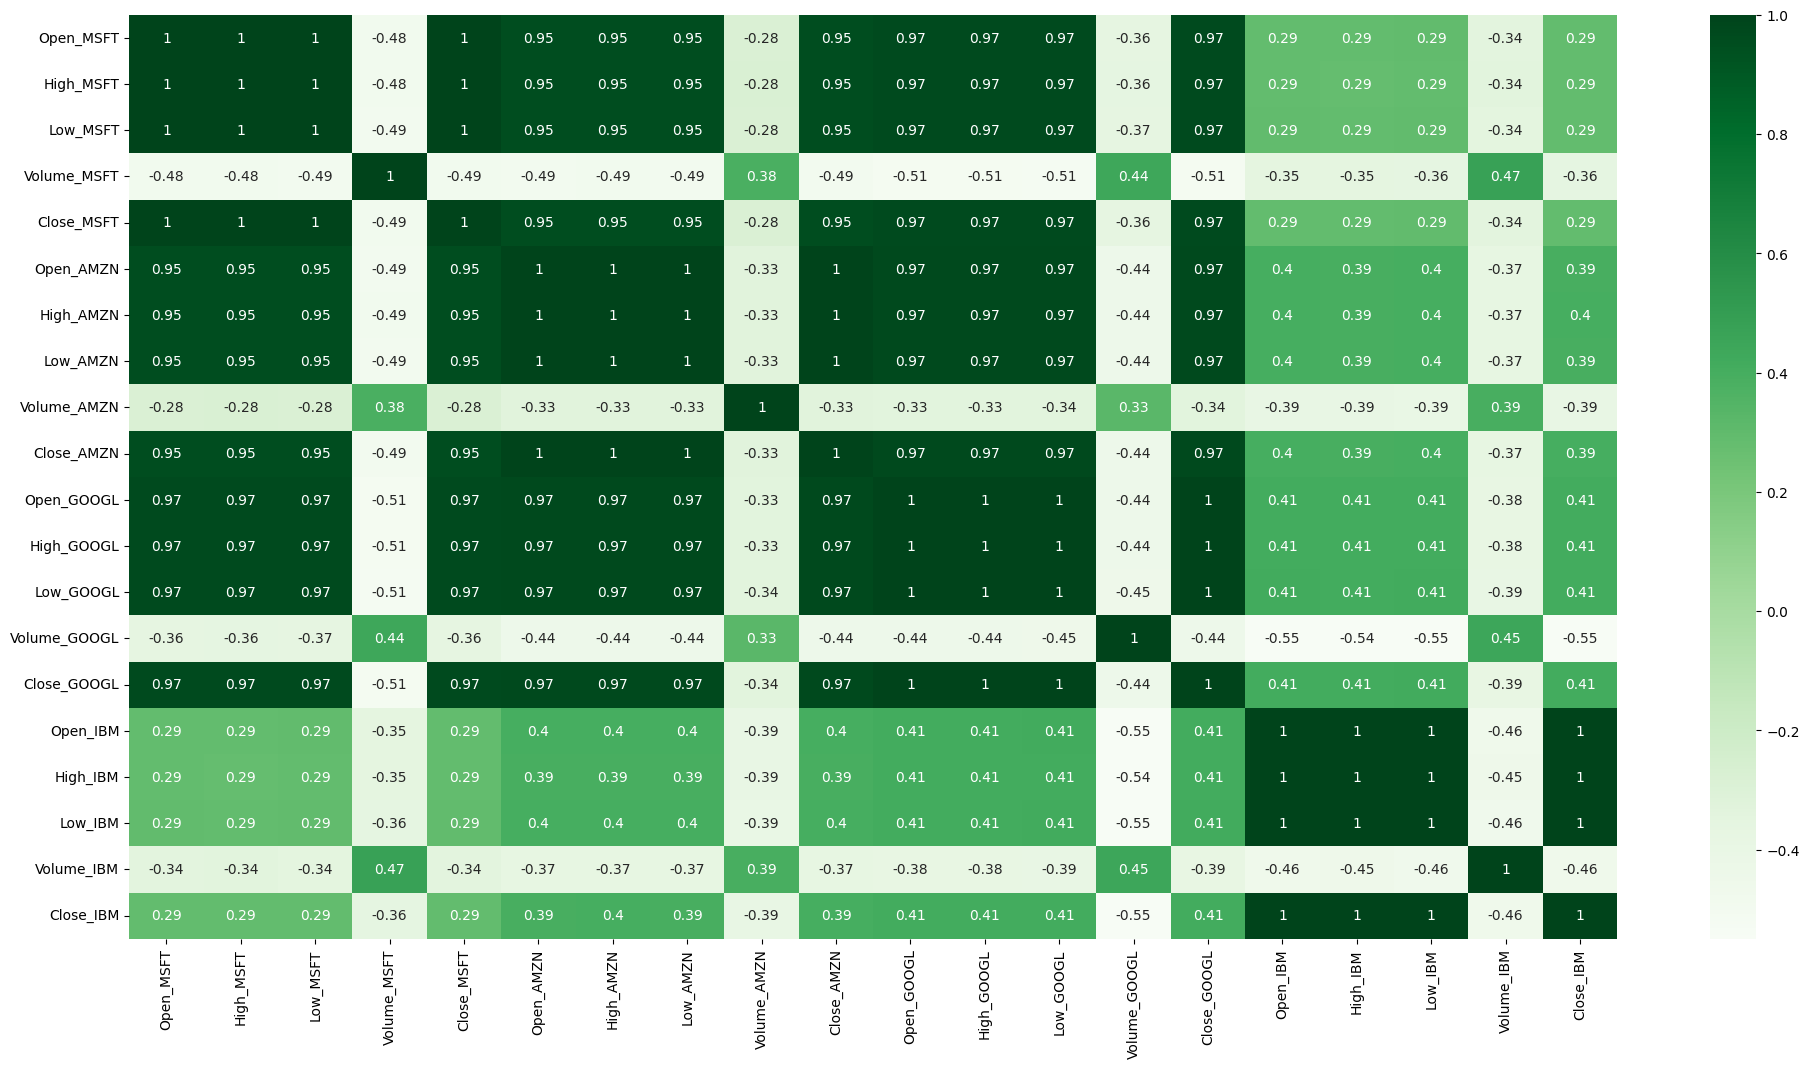

In [9]:
# Analyse correlations
plt.figure(figsize=(24,12))
all_stocks_cor=all_stocks_pivoted.drop(columns=["Date_"])
corr_df=all_stocks_cor.corr()
sns.heatmap(corr_df,annot=True,cmap="Greens")

## Approach 1 - Univariate Analysis

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

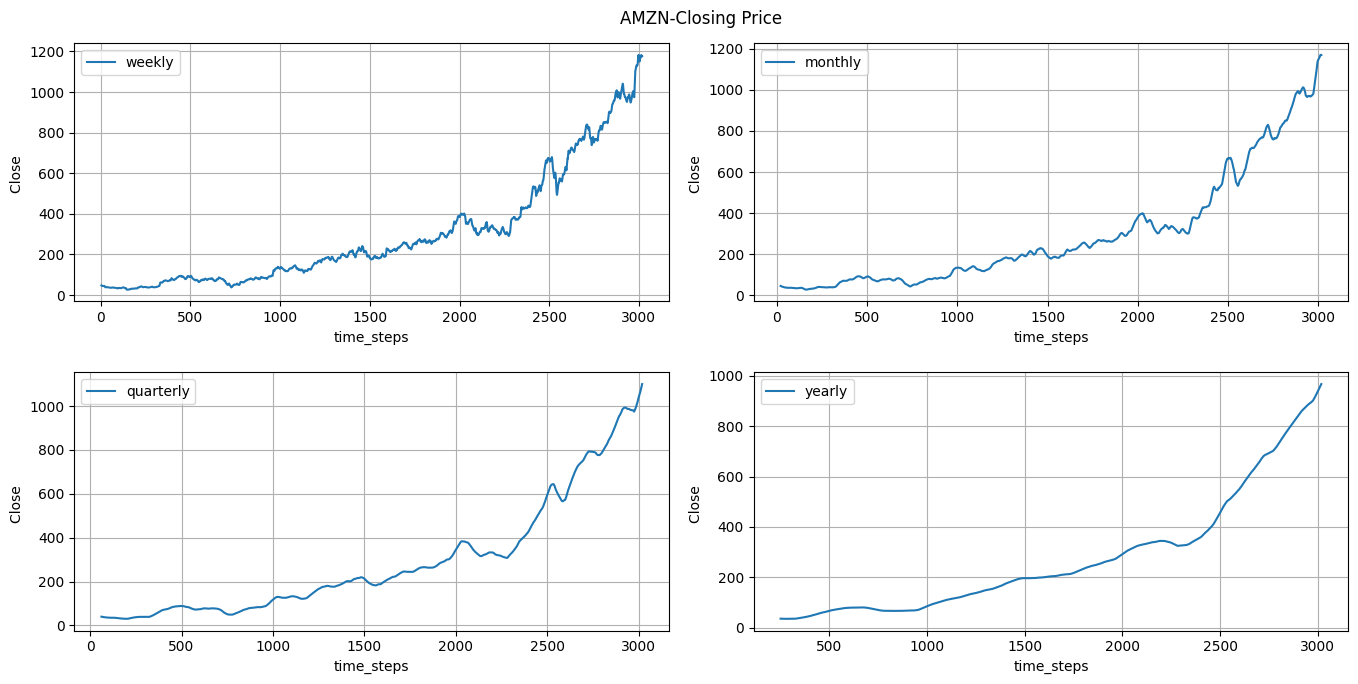

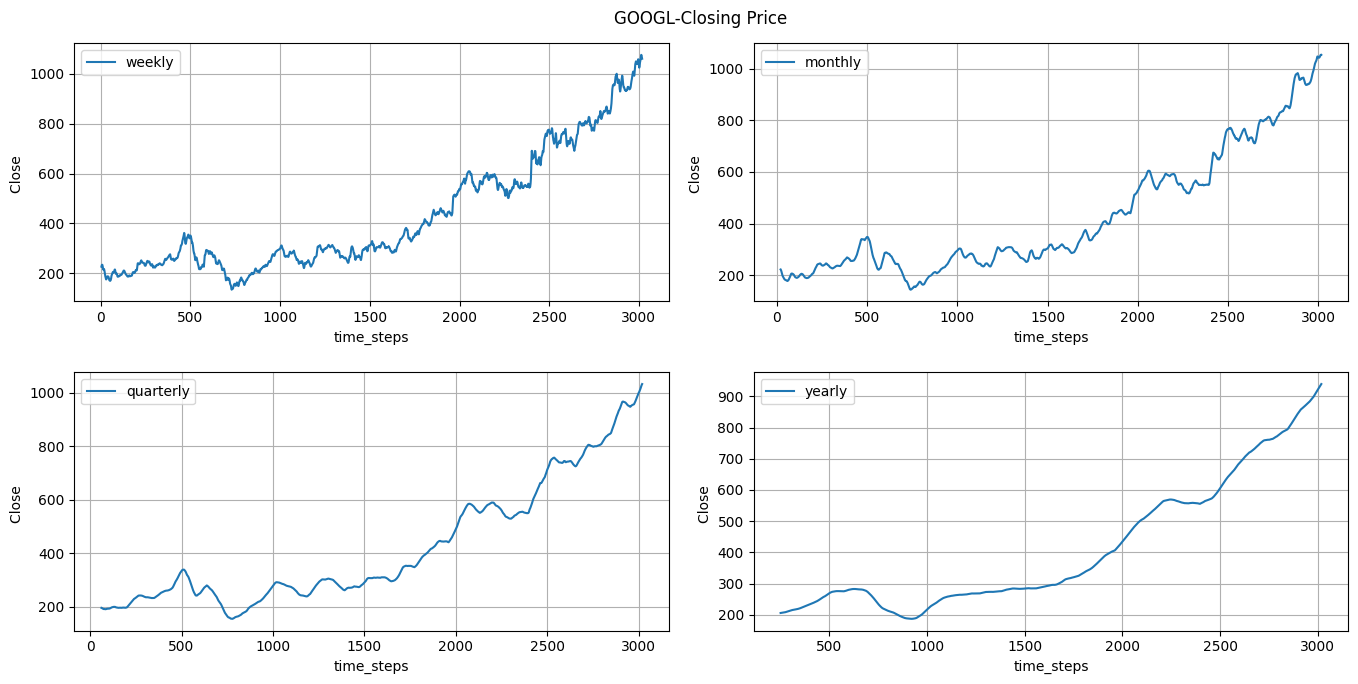

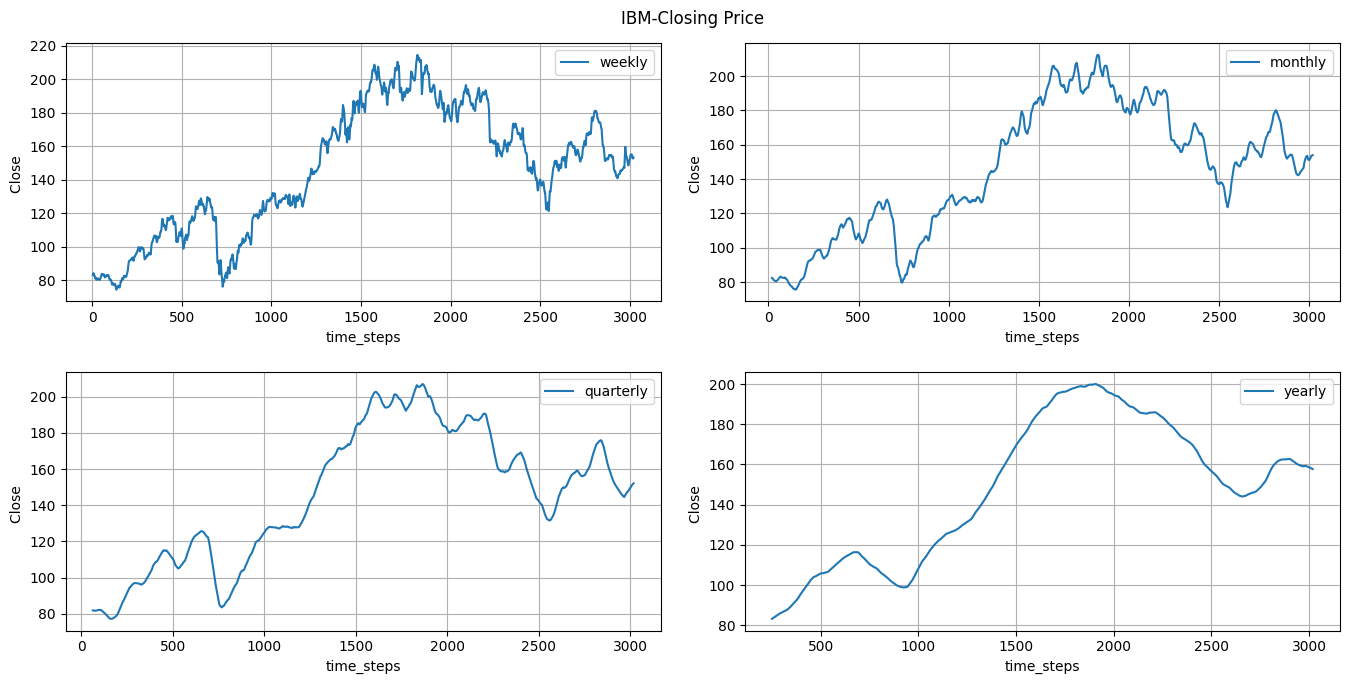

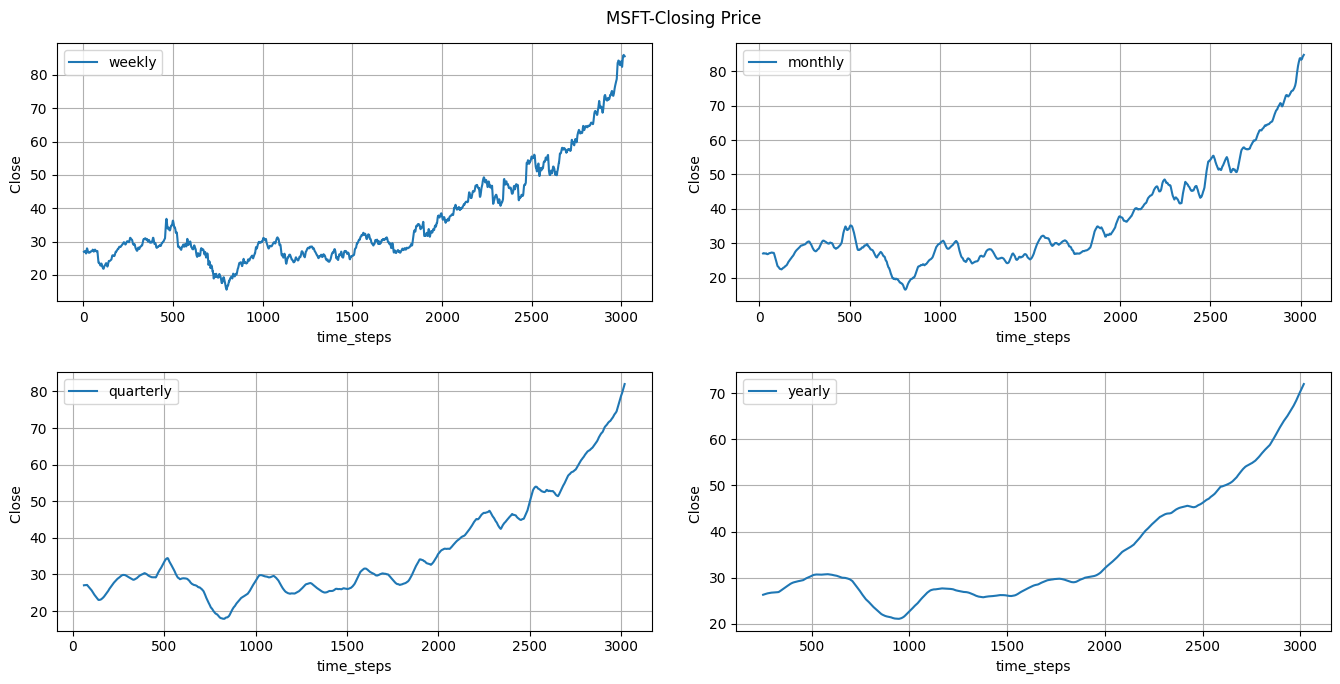

In [10]:
# Checking for patterns in different sequence lengths

## Number of trading days
## Days, months, quarters and yearly trading days
window_size=[5,21,63,252]
window_name=["weekly","monthly","quarterly","yearly"]
def plot_window_pattern(data=None,window_size=list, company_name=None,attribute=None):
  subdata=data.query(f'Name=="{company_name}"').sort_values('Date',ascending=True)
  #### Figure plots ####
  fig,axs=plt.subplots(2,2,figsize=(14,7))
  fig.tight_layout(pad=3.0)
  fig.suptitle(f"{company_name}-Closing Price")
  for window,ax,lbl in zip(window_size,axs.ravel(),window_name):
    x=subdata[attribute].rolling(window=window).mean()
    ax.plot(range(0,len(x)),x,label= f"{lbl}")
    ax.set_xlabel('time_steps')
    ax.set_ylabel(f'{attribute} ')
    ax.legend()
    ax.grid()

    # result = seasonal_decompose(subdata[attribute], model='multiplicative', period=window)
    # result.plot()

  plt.show()
  print("\n")

### Plotting the graphs for different companies ###
plot_window_pattern(data=df_stocks_all,window_size=window_size,company_name="AMZN",attribute="Close")
plot_window_pattern(data=df_stocks_all,window_size=window_size,company_name="GOOGL",attribute="Close")
plot_window_pattern(data=df_stocks_all,window_size=window_size,company_name="IBM",attribute="Close")
plot_window_pattern(data=df_stocks_all,window_size=window_size,company_name="MSFT",attribute="Close")



Comparing all the companies, window size of 63 has much less noise with reasonable number of patterns captured. So, Quarterly basis input is going into the model

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [11]:
# Create data instances from the master data frame using decided window size and window stride
## Final window size
window_size=20
window_stride=1
comp_name=["GOOGL"]
feats=["Close"]
uni_X_train,uni_X_test,uni_y_train,uni_y_test,uni_scalar_x,uni_scalar_y=utils.data_preprocessing(data=all_stocks_pivoted,split_ratio=0.8,window_size=window_size,
                                                                                           window_stride=window_stride,company_name=comp_name,feats=feats)

## scaled input
print(f"X_train:{uni_X_train.shape}\ny_train:{uni_y_train.shape}")
print(f"X_test:{uni_X_test.shape}\ny_test:{uni_y_test.shape}")
#

X_train:(2399, 20, 1)
y_train:(2399, 1)
X_test:(600, 20, 1)
y_test:(600, 1)
X_train:(2399, 20, 1)
y_train:(2399, 1)
X_test:(600, 20, 1)
y_test:(600, 1)


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [12]:
# Create a function that creates a simple RNN model according to the model configuration arguments
### Hyperparametrs
n_units=[32,64,128]
dense_units=[16,32,64]
dropouts=[0.3,0.5]
activation=['relu','tanh']
learning_rate=[5e-4,2e-3,1e-4,10e-3]
opt=['adam','sgd','rmsprop']
### Combinations
configs_list=list(itertools.product(n_units,dense_units,dropouts,activation,learning_rate))
configurations=[]

for config,num in zip(configs_list,range(len(configs_list))):
  configurations.append({'name': f'Config_{num+1}','n_units':config[0],'dense_units':config[1],'dropout':config[2],'activation':config[3],'learning_rate':config[4]})#,'opt':config[5]})# print(configurations)]
print(f"Total number of configurations:{len(configurations)}")

configs_df=pd.DataFrame(configurations)
configs_df


Total number of configurations:144


,name,n_units,dense_units,dropout,activation,learning_rate
0,Config_1,32,16,0.3,relu,0.0005
1,Config_2,32,16,0.3,relu,0.0020
2,Config_3,32,16,0.3,relu,0.0001
3,Config_4,32,16,0.3,relu,0.0100
4,Config_5,32,16,0.3,tanh,0.0005
...,...,...,...,...,...,...
139,Config_140,128,64,0.5,relu,0.0100
140,Config_141,128,64,0.5,tanh,0.0005
141,Config_142,128,64,0.5,tanh,0.0020
142,Config_143,128,64,0.5,tanh,0.0001


#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [13]:
# Find the best configuration based on evaluation metrics
epochs=50
batch_size=32

history_uni_list,metrics_uni_dict,model_id=utils.model_fit(X_train=uni_X_train,X_test=uni_X_test,Y_train=uni_y_train,Y_test=uni_y_test,func=utils.create_simple_rnn_model,configurations=configurations,batch_size=batch_size,epoch=epochs)


In [ ]:
#### Getting the best models using validation metrices
uni_metrics_df=pd.DataFrame(metrics_uni_dict).T.rename(columns={0:"MSE_train",1:"MSE_test",2:"MAE_train",3:"MAE_test",4:"R2_train",5:"R2_test"}).sort_values('R2_test',ascending=False).reset_index()
display(uni_metrics_df.head())
uni_simple_rnn_best_fit=uni_metrics_df.iloc[0]
print(f'best_config:\n')
display(configs_df[configs_df["name"]==uni_simple_rnn_best_fit["index"]])

#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model


uni_best_config_name = uni_simple_rnn_best_fit["index"]  # Get the name of the best configuration
print(uni_best_config_name)
uni_simple_rnn_best_config = configs_df[configs_df["name"]==uni_best_config_name].to_dict('records')
print("best_config\n",uni_simple_rnn_best_config)

hist_uni_sr,metrics_uni_sr,model_uni_sr = utils.model_fit(X_train=uni_X_train,X_test=uni_X_test,Y_train=uni_y_train,Y_test=uni_y_test,
                                                          func=utils.create_simple_rnn_model,configurations=uni_simple_rnn_best_config,
                                                          batch_size=batch_size,epoch=epochs)

model_uni_sr=model_uni_sr[uni_best_config_name]

train_val=model_uni_sr.evaluate(uni_X_train,uni_y_train)
test_val=model_uni_sr.evaluate(uni_X_test,uni_y_test)
print(f"Train Loss:{train_val}\nTest Loss:{test_val}")

### Predict on the test data
y_pred_test = model_uni_sr.predict(uni_X_test)
y_pred_train = model_uni_sr.predict(uni_X_train)

### Print train and test
print(f"Rsquared-score for test:{100*r2_score(uni_y_test,y_pred_test):.2f}%")
print(f"Rsquared-score for train:{100*r2_score(uni_y_train,y_pred_train):.2f}%")

y_pred_test_inv=uni_scalar_y.inverse_transform(y_pred_test)
y_test_inv=uni_scalar_y.inverse_transform(uni_y_test)


Config_133
best_config
 [{'name': 'Config_133', 'n_units': 128, 'dense_units': 64, 'dropout': 0.3, 'activation': 'tanh', 'learning_rate': 0.0005}]
Processing config 1/1 ...MSE:0.0011397279684538554
MAE:0.028549454345067008
R2:0.9706224167248612
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.5863e-05 - mse: 9.5863e-05
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5260e-04 - mse: 7.5260e-04
Train Loss:[0.00013425083307083696, 0.00013425083307083696]
Test Loss:[0.0011397278867661953, 0.0011397278867661953]
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Rsquared-score for test:97.06%
Rsquared-score for train:99.74%


Plotting the actual vs predicted values

Text(0.5, 1.0, 'Univariate Model: GOOGL-Closing price predictions vs actuals (R-squared:97.06%)')

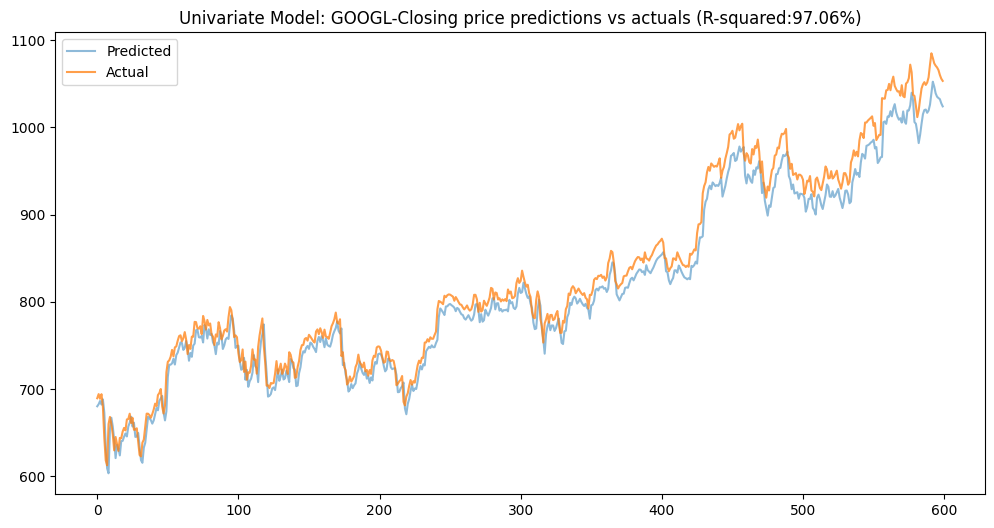

In [ ]:
## Plot Actual VS Predictions

plt.figure(figsize=(12,6))
plt.plot(y_pred_test_inv ,label="Predicted",alpha=0.5)
plt.plot(y_test_inv,label="Actual",alpha=0.75)
plt.legend()
plt.title(f"Univariate Model: {comp_name[0]}-Closing price predictions vs actuals (R-squared:{100*r2_score(uni_y_test,y_pred_test):.2f}%)")


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [ ]:
# Compute the performance of the model on the testing data set
print(f"Mean-squared-error:{mean_squared_error(y_test_inv,y_pred_test_inv)}")
print(f"Mean-absolute-error:{mean_absolute_error(y_test_inv,y_pred_test_inv)}")
print(f"R2-score:{100*r2_score(y_test_inv,y_pred_test_inv):.2f}%")

Mean-squared-error:371.2982227879083
Mean-absolute-error:16.29515841471354
R2-score:97.06%


### Advanced RNN Models

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data


Create a function that builds an advanced RNN model with tunable hyperparameters.

In [14]:
# # Define a function to create a model and specify default values for hyperparameters
### Hyper parameter grid

units=[32,64,128,256]
activation=['relu','tanh']
layers=[1,2]
learning_rate=[1e-4,5e-4,3e-3,1e-3]
optimizer=['adam','sgd','rmsprop']


advanced_configs=list(itertools.product(units,
                  activation,
                  layers,
                  learning_rate,
                  optimizer))

advncd_configs=[]

for config,num in zip(advanced_configs,range(len(advanced_configs))):
  advncd_configs.append({'name': f'Config_{num+1}','units':config[0],'activation':config[1],'layers':config[2],'learning_rate':config[3],'opt':config[4]})
print(f"Total number of configurations:{len(advncd_configs)}")

adv_configs_df=pd.DataFrame(advncd_configs)
adv_configs_df


Total number of configurations:192


,name,units,activation,layers,learning_rate,opt
0,Config_1,32,relu,1,0.0001,adam
1,Config_2,32,relu,1,0.0001,sgd
2,Config_3,32,relu,1,0.0001,rmsprop
3,Config_4,32,relu,1,0.0005,adam
4,Config_5,32,relu,1,0.0005,sgd
...,...,...,...,...,...,...
187,Config_188,256,tanh,2,0.0030,sgd
188,Config_189,256,tanh,2,0.0030,rmsprop
189,Config_190,256,tanh,2,0.0010,adam
190,Config_191,256,tanh,2,0.0010,sgd


In [ ]:
# LSTM - training to fit on the optimal configurations
history_uni_lstm,metrics_uni_lstm,model_id_lstm=utils.model_fit(X_train=uni_X_train,X_test=uni_X_test,Y_train=uni_y_train,Y_test=uni_y_test,func=utils.create_lstm_model,configurations=advncd_configs,batch_size=batch_size,epoch=epochs)


Processing config 5/192 ...MSE:0.00103693570794681
MAE:0.025640067160665615
R2:0.973271985987588
Processing config 7/192 ...MSE:0.00037027247354436273
MAE:0.014390125808517486
R2:0.9904558712893589
Processing config 8/192 ...MSE:0.0004231041995128208
MAE:0.01620448595585091
R2:0.9890940827993271
Processing config 9/192 ...MSE:0.00031033787118737733
MAE:0.012985286843650273
R2:0.9920007432417365
Processing config 11/192 ...MSE:0.0013217358981903538
MAE:0.026459279969333643
R2:0.965930987488617
Processing config 12/192 ...MSE:0.00038896819179424515
MAE:0.01452813998974189
R2:0.9899739711912858
Processing config 16/192 ...MSE:0.0012679082399734223
MAE:0.02744200012353122
R2:0.967318447089103
Processing config 19/192 ...MSE:0.0004185803713435225
MAE:0.015412378776934356
R2:0.9892106888162403
Processing config 20/192 ...MSE:0.0004975055473331116
MAE:0.01677770081635148
R2:0.987176316585045
Processing config 22/192 ...MSE:0.0005225566850778147
MAE:0.01757251971068631
R2:0.9865305994441116
Pr

In [ ]:
#### Getting the best models using validation metrices
uni_adv_config_name,uni_adv_config=utils.get_best_config(metrics_uni_lstm,adv_configs_df)
print(uni_adv_config_name)
display(uni_adv_config)

In [15]:
### Create the model with a combination of potentially optimal hyperparameter values and retrain the model
lstm_y_pred_test,y_test_inv,lstm_y_pred_train,y_train_inv=utils.retrain_model_with_best_config(X_train=uni_X_train,X_test=uni_X_test,
                                                                                         Y_train=uni_y_train,Y_test=uni_y_test,
                                                                                         func1=utils.model_fit,func2=utils.create_lstm_model,
                                                                                         best_fit_name="Config_19", best_config=None,
                                                                                        config_df=adv_configs_df,batch_size=batch_size,epoch=epochs,y_scalar=uni_scalar_y)




Processing config 1/1 ...MSE:0.0014858494513422605
MAE:0.03215371111884821
R2:0.961700802999208
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.6215e-05 - mse: 9.6215e-05
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.5159e-04 - mse: 9.5159e-04
Train Loss:[0.00013896818563807756, 0.00013896818563807756]
Test Loss:[0.0014858496142551303, 0.0014858496142551303]
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Rsquared-score for test:96.17%
Rsquared-score for train:99.73%


Plotting the actual vs predicted values

Mean-squared-error:484.05709119932675
Mean-absolute-error:18.352360510253906
R2-score:96.17%


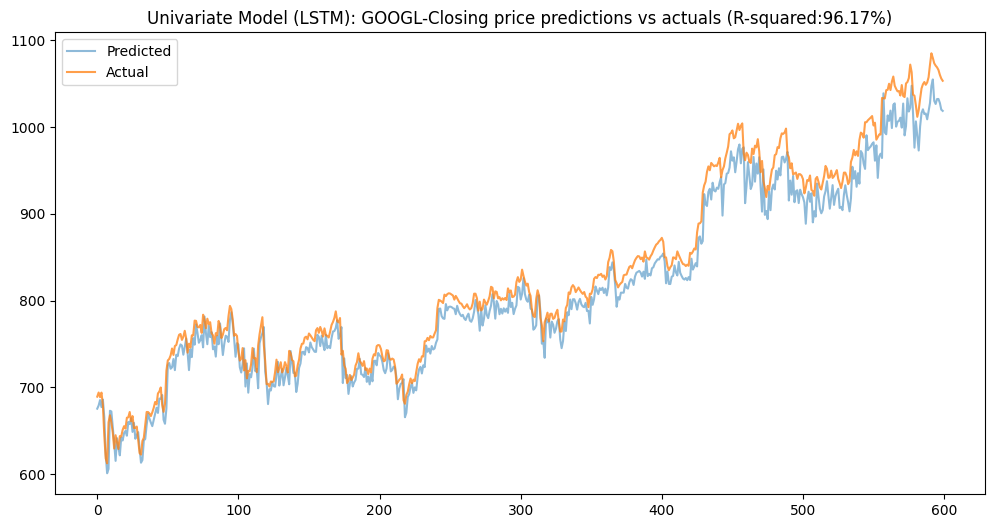

In [16]:
## Plot Actual VS Predictions

plt.figure(figsize=(12,6))
plt.plot(lstm_y_pred_test ,label="Predicted",alpha=0.5)
plt.plot(y_test_inv,label="Actual",alpha=0.75)
plt.legend()
plt.title(f"Univariate Model (LSTM): {comp_name[0]}-Closing price predictions vs actuals (R-squared:{100*r2_score(y_test_inv,lstm_y_pred_test):.2f}%)")

# Compute the performance of the model on the testing data set
print(f"Mean-squared-error:{mean_squared_error(y_test_inv,lstm_y_pred_test)}")
print(f"Mean-absolute-error:{mean_absolute_error(y_test_inv,lstm_y_pred_test)}")
print(f"R2-score:{100*r2_score(y_test_inv,lstm_y_pred_test):.2f}%")


## Approach -2 Cross company Modelling


In this section, we will use recurrent neural networks to predict stock prices for more than one company.

Input for cross company multivaraite modelling

In [ ]:
cross_X_train,cross_X_test,cross_y_train,cross_y_test,cross_scalar_x,cross_scalar_y=utils.data_preprocessing(data=all_stocks_pivoted,split_ratio=0.8,window_size=window_size,
                                                                                           window_stride=window_stride,company_name=None,feats=None,target_columns=comp_name)

## scaled input
print(f"X_train:{cross_X_train.shape}\ny_train:{cross_y_train.shape}")
print(f"X_test:{cross_X_test.shape}\ny_test:{cross_y_test.shape}")


X_train:(2399, 20, 20)
y_train:(2399, 1)
X_test:(600, 20, 20)
y_test:(600, 1)
X_train:(2399, 20, 20)
y_train:(2399, 1)
X_test:(600, 20, 20)
y_test:(600, 1)


In [ ]:
### Train simple RNN model
history_cross_sr,metrics_cross_sr,model_id_cross_sr=utils.model_fit(X_train=cross_X_train,X_test=cross_X_test,Y_train=cross_y_train,Y_test=cross_y_test,func=utils.create_simple_rnn_model,
                                                                    configurations=configurations,batch_size=batch_size,epoch=epochs)

Processing config 42/144 ...MSE:0.0011309781782545274
MAE:0.02763122949541268
R2:0.9708479509728006
Processing config 83/144 ...MSE:0.0032769425586425646
MAE:0.04458702429769035
R2:0.9155336575314847
Processing config 144/144 ...

,index,MSE_train,MSE_test,MAE_train,MAE_test,R2_train,R2_test
0,Config_42,0.001794,0.001131,0.035120,0.027631,0.965499,0.970848
1,Config_83,0.003071,0.003277,0.039105,0.044587,0.940943,0.915534
2,Config_134,0.000726,0.005212,0.020407,0.050896,0.986045,0.865643
3,Config_53,0.000274,0.010198,0.011879,0.078959,0.994733,0.737148
4,Config_51,0.001804,0.011830,0.033891,0.097635,0.965314,0.695074


best_config:

Config_42


,name,n_units,dense_units,dropout,activation,learning_rate
41,Config_42,32,64,0.5,relu,0.002


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0047 - mse: 0.0047
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - mse: 0.0045
Train Loss:[0.003058471018448472, 0.003058471018448472]
Test Loss:[0.008185172453522682, 0.008185172453522682]
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Rsquared-score for test:78.90%
Rsquared-score for train:94.12%
Mean-squared-error:2666.5503094037185
Mean-absolute-error:46.199839583333336
R2-score:78.90%


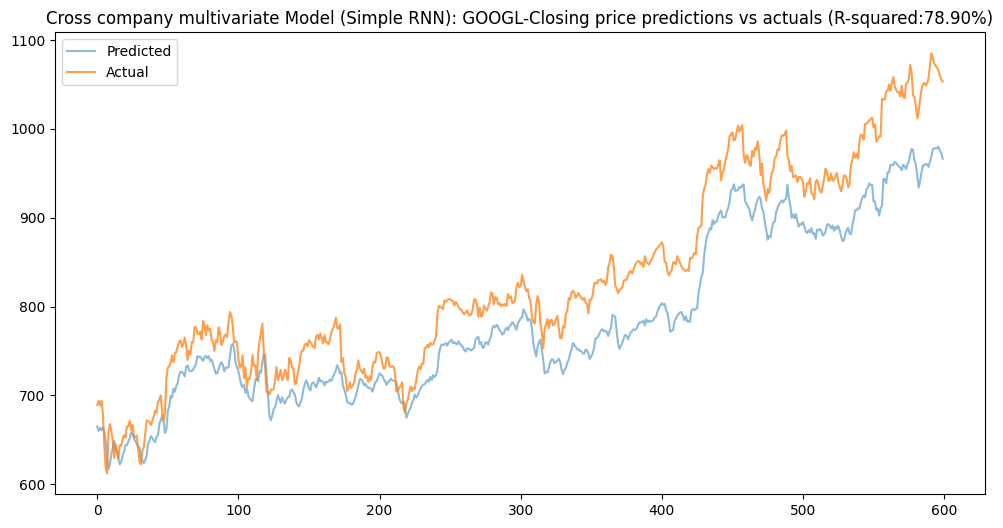

In [ ]:
### best config for cross model simple RNN
cross_best_fit_name,cross_best_config=utils.get_best_config(metrics_cross_sr,configs_df)
print(cross_best_fit_name)
display(cross_best_config)

### Fit on the best config

sr_cross_y_pred_test,cross_y_test_inv,sr_cross_y_pred_train,cross_y_train_inv=utils.retrain_model_with_best_config(X_train=cross_X_train,X_test=cross_X_test,
                                                                                         Y_train=cross_y_train,Y_test=cross_y_test,
                                                                                         func1=utils.model_fit,func2=utils.create_simple_rnn_model,
                                                                                         best_fit_name=cross_best_fit_name, best_config=cross_best_config,
                                                                                        config_df=configs_df,batch_size=batch_size,epoch=epochs,y_scalar=cross_scalar_y)
## Plot Actual VS Predictions

plt.figure(figsize=(12,6))
plt.plot(sr_cross_y_pred_test ,label="Predicted",alpha=0.5)
plt.plot(cross_y_test_inv,label="Actual",alpha=0.75)
plt.legend()
plt.title(f"Cross company multivariate Model (Simple RNN): {comp_name[0]}-Closing price predictions vs actuals (R-squared:{100*r2_score(cross_y_test_inv,sr_cross_y_pred_test):.2f}%)")

# Compute the performance of the model on the testing data set
print(f"Mean-squared-error:{mean_squared_error(cross_y_test_inv,sr_cross_y_pred_test)}")
print(f"Mean-absolute-error:{mean_absolute_error(cross_y_test_inv,sr_cross_y_pred_test)}")
print(f"R2-score:{100*r2_score(cross_y_test_inv,sr_cross_y_pred_test):.2f}%")


In [ ]:
### LSTM on cross company modelling
history_cross_lstm,metrics_cross_lstm,model_id_cross_lstm=utils.model_fit(X_train=cross_X_train,X_test=cross_X_test,Y_train=cross_y_train,Y_test=cross_y_test,func=utils.create_lstm_model,
                                                                    configurations=advncd_configs,batch_size=batch_size,epoch=epochs)

Processing config 1/1 ...MSE:0.0007010425501849752
MAE:0.020436776185921466
R2:0.9819299548071864
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.9483e-05 - mse: 8.9483e-05
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7941e-04 - mse: 4.7941e-04
Train Loss:[0.00012066998897353187, 0.00012066998897353187]
Test Loss:[0.0007010426488704979, 0.0007010426488704979]
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Rsquared-score for test:98.19%
Rsquared-score for train:99.77%
Mean-squared-error:228.38423763433917
Mean-absolute-error:11.664690596516923
R2-score:98.19%


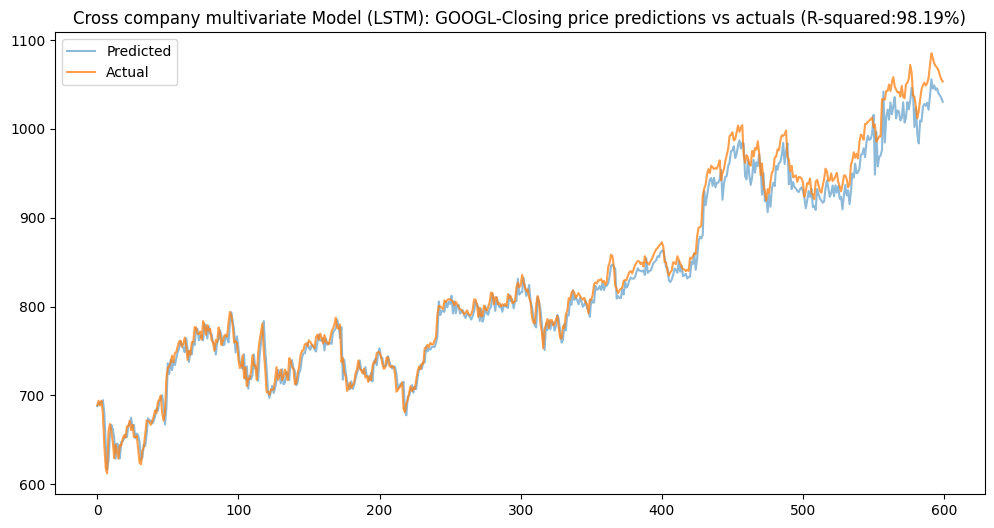

In [ ]:
### best config for cross modelling on LSTM
# cross_lstm_best_fit_name,cross_lstm_best_config=utils.get_best_config(metrics_cross_lstm,adv_configs_df)
# print(cross_lstm_best_fit_name)
# display(cross_lstm_best_config)

### Retrain with best config
lstm_cross_y_pred_test,cross_y_test_inv,lstm_cross_y_pred_train,cross_y_train_inv=utils.retrain_model_with_best_config(X_train=cross_X_train,X_test=cross_X_test,
                                                                                         Y_train=cross_y_train,Y_test=cross_y_test,func1=utils.model_fit,func2=utils.create_lstm_model,
                                                                                         best_fit_name="Config_56", best_config=None,
                                                                                        config_df=adv_configs_df,batch_size=batch_size,epoch=epochs,y_scalar=cross_scalar_y)

## Plot Actual VS Predictions

plt.figure(figsize=(12,6))
plt.plot(lstm_cross_y_pred_test ,label="Predicted",alpha=0.5)
plt.plot(cross_y_test_inv,label="Actual",alpha=0.75)
plt.legend()
plt.title(f"Cross company multivariate Model (LSTM): {comp_name[0]}-Closing price predictions vs actuals (R-squared:{100*r2_score(cross_y_test_inv,lstm_cross_y_pred_test):.2f}%)")

# Compute the performance of the model on the testing data set
print(f"Mean-squared-error:{mean_squared_error(cross_y_test_inv,lstm_cross_y_pred_test)}")
print(f"Mean-absolute-error:{mean_absolute_error(cross_y_test_inv,lstm_cross_y_pred_test)}")
print(f"R2-score:{100*r2_score(cross_y_test_inv,lstm_cross_y_pred_test):.2f}%")


## Approach - 3 Cross company Modelling with multiple outputs


In [ ]:
# Input for multi-outputs
comp_lst=['GOOGL','AMZN','MSFT','IBM']
multi_X_train,multi_X_test,multi_y_train,multi_y_test,multi_scalar_x,multi_scalar_y=utils.data_preprocessing(data=all_stocks_pivoted,split_ratio=0.8,window_size=window_size,
                                                                                           window_stride=window_stride,company_name=None,feats=None,target_columns=comp_lst)
## scaled input
print(f"X_train:{multi_X_train.shape}\ny_train:{multi_y_train.shape}")
print(f"X_test:{multi_X_test.shape}\ny_test:{multi_y_test.shape}")



In [ ]:
# Train a simple RNN model
history_multi_sr,metrics_multi_sr,model_id_multi_sr=utils.model_fit(X_train=multi_X_train,X_test=multi_X_test,
                                                                    Y_train=multi_y_train,
                                                                    Y_test=multi_y_test,
                                                                    func=utils.create_simple_rnn_model,
                                                                    configurations=configurations,
                                                                    batch_size=batch_size,epoch=epochs)


Processing config 144/144 ...

,index,MSE_train,MSE_test,MAE_train,MAE_test,R2_train,R2_test
0,Config_37,0.000100,0.006138,0.007041,0.047380,0.984070,0.317399
1,Config_130,0.000892,0.008531,0.021861,0.052867,0.878147,0.274343
2,Config_85,0.000188,0.013268,0.009703,0.068949,0.974609,0.189911
3,Config_133,0.000148,0.011087,0.008427,0.068607,0.970229,0.184493
4,Config_17,0.000622,0.017146,0.018600,0.075664,0.877675,-0.023856


best_config:

Config_37


,name,n_units,dense_units,dropout,activation,learning_rate
36,Config_37,32,64,0.3,tanh,0.0005


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6010e-04 - mse: 1.6010e-04
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - mse: 0.0047
Train Loss:[0.00015213248843792826, 0.00015213248843792826]
Test Loss:[0.013952878303825855, 0.013952878303825855]
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Rsquared-score for test:41.75%
Rsquared-score for train:98.08%
Mean-squared-error:6536.910380110806
Mean-absolute-error:48.34409461809794
R2-score:41.75%


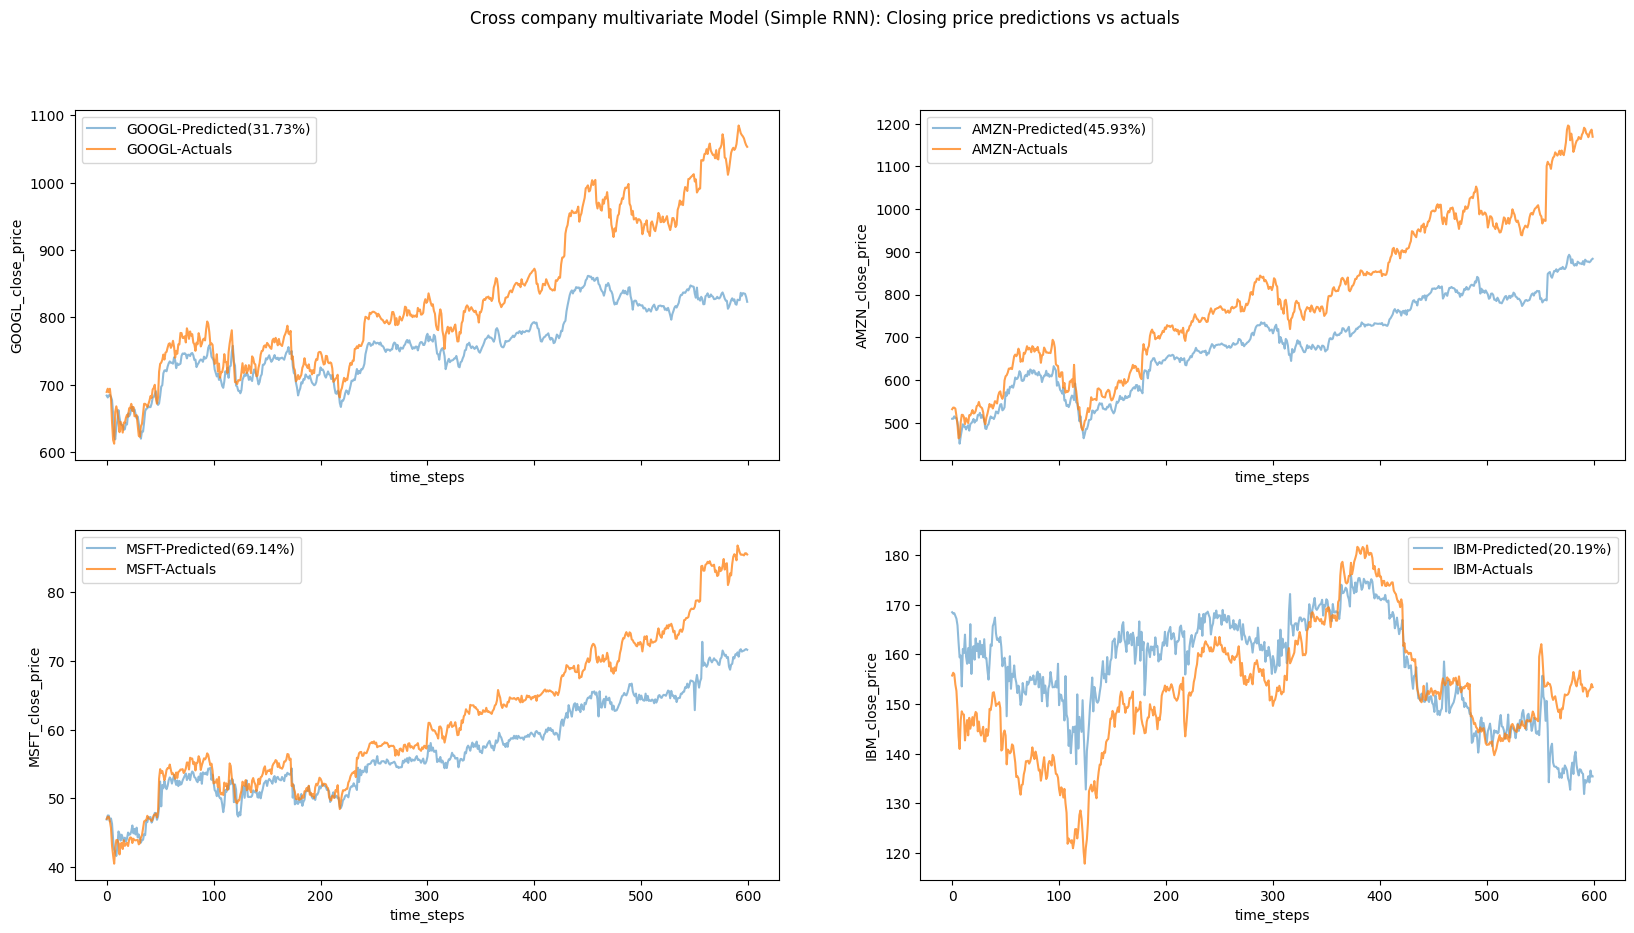

In [ ]:
### Best simple RNN config
multi_sr_best_fit_name,multi_sr_best_config=utils.get_best_config(metrics_multi_sr,configs_df)
print(multi_sr_best_fit_name)
display(multi_sr_best_config)

### Retrain with the best config
sr_multi_y_pred_test,multi_y_test_inv,sr_multi_y_pred_train,multi_y_train_inv=utils.retrain_model_with_best_config(X_train=multi_X_train,X_test=multi_X_test,
                                                                                         Y_train=multi_y_train,Y_test=multi_y_test,
                                                                                         func1=utils.model_fit,func2=utils.create_simple_rnn_model,
                                                                                         best_fit_name=multi_sr_best_fit_name, best_config=multi_sr_best_config,
                                                                                        config_df=configs_df,batch_size=batch_size,epoch=epochs,y_scalar=multi_scalar_y)

## Plot Actual VS Predictions

fig,ax=plt.subplots(2,2,figsize=(20,10),sharex=True)
fig.suptitle(f"Cross company multivariate Model (Simple RNN): Closing price predictions vs actuals")
r2_squared_scores=r2_score(multi_y_test_inv,sr_multi_y_pred_test, multioutput='raw_values')
for axs,i in zip(ax.ravel(),range(sr_multi_y_pred_test.shape[1])):
  axs.plot(sr_multi_y_pred_test[:,i] ,label=f"{comp_lst[i]}-Predicted({100*r2_squared_scores[i]:.2f}%)",alpha=0.5)
  axs.plot(multi_y_test_inv[:,i],label=f"{comp_lst[i]}-Actuals",alpha=0.75)
  axs.set_xlabel('time_steps')
  axs.set_ylabel(f'{comp_lst[i]}_close_price')
  axs.legend()

# Compute the performance of the model on the testing data set
print(f"Mean-squared-error:{mean_squared_error(multi_y_test_inv,sr_multi_y_pred_test)}")
print(f"Mean-absolute-error:{mean_absolute_error(multi_y_test_inv,sr_multi_y_pred_test)}")
print(f"R2-score:{100*r2_score(multi_y_test_inv,sr_multi_y_pred_test):.2f}%")

In [ ]:
### LSTM modelling
history_multi_lstm,metrics_multi_lstm,model_id_multi_lstm=utils.model_fit(X_train=multi_X_train,X_test=multi_X_test,
                                                                    Y_train=multi_y_train,
                                                                    Y_test=multi_y_test,
                                                                    func=utils.create_lstm_model, configurations=advncd_configs,
                                                                    batch_size=batch_size,epoch=epochs)



In [ ]:
### pick the best muti-output LSTM
multi_lstm_best_fit_name,multi_lstm_best_config=utils.get_best_config(metrics_multi_lstm,adv_configs_df)
print(multi_lstm_best_fit_name)
display(multi_lstm_best_config)

### Retrain with the best config
lstm_multi_y_pred_test,multi_y_test_inv,lstm_multi_y_pred_train,multi_y_train_inv=utils.retrain_model_with_best_config(X_train=multi_X_train,X_test=multi_X_test,
                                                                                         Y_train=multi_y_train,Y_test=multi_y_test,
                                                                                         func1=utils.model_fit,func2=utils.create_lstm_model,best_fit_name=multi_lstm_best_fit_name, best_config=multi_lstm_best_config,
                                                                                        config_df=adv_configs_df,batch_size=batch_size,epoch=epochs,y_scalar=multi_scalar_y)

### Plot Actual VS Predicted
fig,ax=plt.subplots(2,2,figsize=(20,10),sharex=True)
fig.suptitle(f"Cross company multivariate Model (LSTM): Closing price predictions vs actuals")
r2_squared_scores=r2_score(multi_y_test_inv,lstm_multi_y_pred_test, multioutput='raw_values')
for axs,i in zip(ax.ravel(),range(lstm_multi_y_pred_test.shape[1])):
  axs.plot(lstm_multi_y_pred_test[:,i] ,label=f"{comp_lst[i]}-Predicted({100*r2_squared_scores[i]:.2f}%)",alpha=0.5)
  axs.plot(multi_y_test_inv[:,i],label=f"{comp_lst[i]}-Actuals",alpha=0.75)
  axs.set_xlabel('time_steps')
  axs.set_ylabel(f'{comp_lst[i]}_close_price')
  axs.legend()

# Compute the performance of the model on the testing data set
print(f"Mean-squared-error:{mean_squared_error(multi_y_test_inv,lstm_multi_y_pred_test)}")
print(f"Mean-absolute-error:{mean_absolute_error(multi_y_test_inv,lstm_multi_y_pred_test)}")
print(f"R2-score:{100*r2_score(multi_y_test_inv,lstm_multi_y_pred_test):.2f}%")

## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

## LSTM vs Simple RNN
 - A window size of 5 trading days is taken into consideration for training and prediction the below models.
 - The best configurations are as follows:

| Model       | Units | Layers | Dense Units | Dropout | Activation | Learning Rate | Optimizer |
|-------------|--------|--------|--------------|---------|------------|----------------|-----------|
| **LSTM**     | 256    | 2      | —            | —       | tanh       | 0.001          | adam      |
| **Simple RNN** | 64     | 2 | 64           | 0.5     | relu       | 0.002          | adam (assumed) |

---

## 📊 Model Performance Summary

| Metric                  | **LSTM**                | **Simple RNN**           |
|-------------------------|--------------------------|---------------------------|
| **R² Score**            | 99.38%                   | 97.70%                    |
| **Mean Squared Error**  | 199.55                   | 738.85                    |
| **Mean Absolute Error** | 10.15                    | 23.42                     |

---

### ✅ Interpretation

- **LSTM performs significantly better** than Simple RNN:
  - R² is higher → LSTM explains more of the variance.
  - MSE and MAE are lower → smaller prediction errors.
- This suggests LSTM captures time dependencies in stock prices more
effectively.

- Lower errors:

 - MSE of LSTM is ~199 vs ~739 for Simple RNN → LSTM makes far smaller squared errors.
 - MAE of LSTM is ~10.15 vs ~23.42 → LSTM predictions are closer to actual values on average.

> 📌 **Conclusion**: Use LSTM for more accurate stock prediction results.